## CRIAÇÃO DE PERSONAS VOLTADAS AO MERCADO DE CRÉDITO UTILIZANDO K-MEANS DE FORMA SEMI-SUPERVISIONADA PARA CONSTRUÇÃO DE UMA ÁRVORE DE CLUSTER

#### CONECTANDO O NOTEBOOK AO SE E IMPORTANDO AS LIBS NECESSÁRIAS

In [3]:
%run -i '/home/.Turing/TuringCredentialsAccess.py3'
%run -i '/home/.Turing/TuringLabFunctions.py3'

------- Playground LabTuring Data Science ----------------
---------- Functions loaded successfully -----------------
------------------ Last update: --------------------------
------------------- 01/04/2020 ---------------------------
----------------------------------------------------------


In [18]:
from sklearn import preprocessing
import matplotlib.pyplot as plt 
plt.rc("font", size=14)
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import seaborn as sns
sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)
import pandas as pd                                    # Manipulação de tabelas
import numpy as np                                     # Operações matemáticas
import warnings                                        # Remover warnings
import boto3                                           # Manipular funções dentro da AWS
import gc                                              # Limpa memória do cache
from sklearn.metrics import roc_auc_score
from sklearn import datasets, linear_model
from sklearn.model_selection import StratifiedKFold    # Cria KFold estratificado
from sklearn.model_selection import RandomizedSearchCV # Busca Aleatória de Parâmetros
import scipy.stats
import matplotlib.image as mpimg
import tempfile
warnings.filterwarnings("ignore")             # Ignora warnings
pd.set_option('display.max_columns', None)    # Remove limitador de colunas quando mostra a tabela

In [13]:
NM_BUCKET      = 'turing-bkt-via-varejo-prod'
ID_EMPRESA     = '1019'
S3fs, S3session, S3client, S3resource = TuringUsersCredentialsControl(ID_EMPRESA)
CAMINHO  = 'Bases/MODELAGEM/GOOGLE/'

### O QUE SÃO PERSONAS?

A persona é um método de segmentação de quem o seu negócio quer atingir no mercado. Neste caso, traremos aqui Personas voltadas ao mercado de crédito. 
Ou seja, o objetivo é utilizar dados reais de clientes já existentes para segmentá-los ao ponto de encontrar perfis diferentes que respondam inadimplências diferentes.

### COMO SERÃO DESENVOLVIDAS AS PERSONAS?

As personas foram desenvolvidas atráves de uma árvore de clusters. Na primeira "camada" dessa árvore criaremos, por regra, 3 ramos referentes ao segmento que cada cliente pertence: Novo (se novo em crédito), Ativo (cliente que fetuou compras frequentemente) e Inativo (cliente que não efetua compras há mais de 18 meses). Essa segmentação por regra permite uma maior interpretabilidade da persona formada ao final da árvore. 

Na segunda camada da árvore, denominada de ETL1,  criamos uma "ETL" para conseguir identificar possíveis segmentos de ocupação de cada cliente, dado a CBO (Código Brasileiro de Ocupação) de cada cliente. Bem como, criamos regras acerca das demais variáveis participantes do modelo, prevendo também situações de não informação (missings). Por fim, aplicamos essas regras, separadamente aos clientes Novo, Ativo e Inativo, resultando em 9 clusters, ainda por regra, mas dessa vez usando NPL para agrupar os com características semelhantes. 

Na terceira camada, denominada de ETL2, alicamos às variáveis do modelo uma hierarquização por inadimplência. Isso permite que todas as variáveis categóricas participem do modelo respeitando a similaridade acerca de nosso principal objeto - " A INADIMPLÊNCIA". Dessa forma, retiramos a subjetividade da numeração de cada variável, além de possibilitar a aplicação de algorítmos de classificação simples, como o K-Means. Em seguida, com os 9 clusters com as variáveis já "numeralizadas", aplicamos o critério de otimização por inércia na técnica K-Means, a fim de encontrar o número ideal de sub-clusters dentro de cada um dos 9 clusters. Por fim, com os números ideais de sub-clusters definidos dentro de cada dos 9 clusters, aplicamos mais uma vez a técnica K-Means, encontrando todos os sub-clusters.

Por fim, para última camada da árvore, denominada de Redução, aplicamos regras para definição de faixas de risco (pela inadimplência). Essas regras podem ser analíticas ou por solicitação de alguma estratégia política. No estudo em questão, utilizamos os percentis (20%, 40%, 60% e 80%)  da inadimplência geral para dividir a inadimplência em 5 faixas.  Feito isso, agrupamos os clusters conforme a faixa de risco a qual pertence. Contudo, esse agrupamento deve ser limitado aos cluster construídos a partir do mesmo ramo da árvore de clusterização. Ou seja, dentro de um dos 9 clusters que te deu origem. Isto permite que o agrupamento não resulte na perca de interpretabilidade na "Persona Final", mantendo, por exemplo as características de segmento (NOVO/ATIVO  ou INATIVO) e função (AUTÔNOMO/FUNÇÃO IDENTIFICADA ou FUNÇÃO NÃO IDENTIFICADA) em caráter de unicidade. Desta forma, tínhamos um range de possibilidades de agrupamento que iria de 9 á 45 (ao final foram encontrados 38 no total). 

Abaixo, para facilitar a visualização do experimento, um desenho da árvore construída:





In [28]:
s3 = boto3.resource('s3', region_name='us-east-2')
bucket = s3.Bucket(NM_BUCKET)
object = bucket.Object(CAMINHO + 'pers.png')
tmp = tempfile.NamedTemporaryFile()

with open(tmp.name, 'wb') as f:
    object.download_fileobj(f)
    img=mpimg.imread(tmp.name)

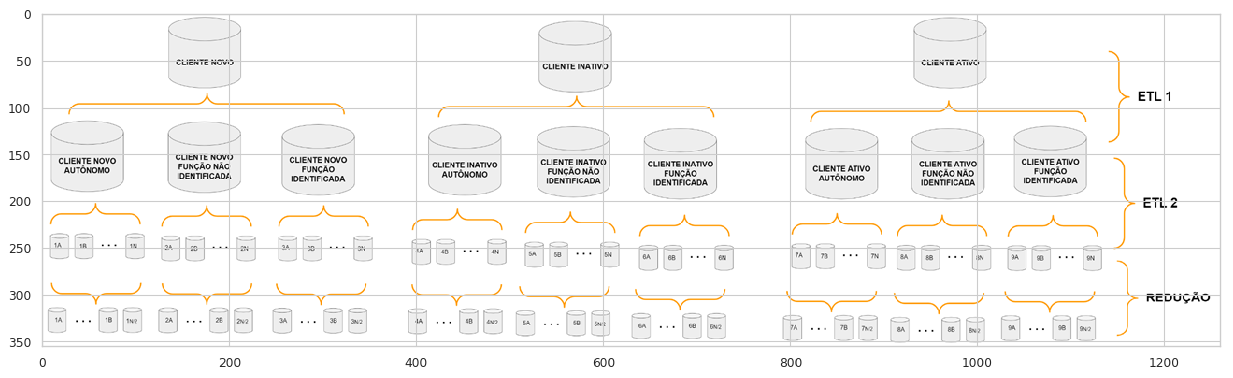

In [29]:
fig=plt.figure(figsize=(19, 17), dpi= 80, facecolor='w', edgecolor='k')
plt.imshow(img)

### IMPORTANDO A BASE 

In [19]:
ARQUIVO_BASE ='CRED20_SEGM_JULSET19_CL.txt'
BASE  = boto3.client('s3').get_object(Bucket=NM_BUCKET, Key=CAMINHO + ARQUIVO_BASE)
BASE = pd.read_csv(BASE['Body'], sep=';', encoding='latin-1') # Rodando base Full
#BASE['DT_CONSULTA'] = pd.to_datetime(BASE['DT_CONSULTA'])
# Criando Index
BASE=BASE.reset_index()
BASE = BASE[BASE['DECISAO_FINAL']=='APV']
BASE = BASE.drop_duplicates(subset=['CD_CLI'])

## CONSTRUÇÃO DAS FUNÇÕES PARA ETL E TRATAMENTO DAS VARIÁVEIS 

In [30]:
def setor_seguranca(base):
    seguranca = []
    base = base.dropna(subset=['DESCRICAO_CBO']).reset_index()
    for i in range(0,len(base)):
        aux = 'PORTE' in base['DESCRICAO_CBO'][i] or 'VIGIA' in base['DESCRICAO_CBO'][i] or 'SEGUR' in base['DESCRICAO_CBO'][i] or 'RECEP' in base['DESCRICAO_CBO'][i]
        seguranca.append(aux)
    base['FLAG_SEGURANCA'] = seguranca
    return base

def setor_construcao_civil(base):
    obras = []
    base = base.dropna(subset=['DESCRICAO_CBO']).reset_index()
    for i in range(0,len(base)):
        aux = 'PINT' in base['DESCRICAO_CBO'][i] or  'OBRA' in base['DESCRICAO_CBO'][i] or 'CIVI' in base['DESCRICAO_CBO'][i] or 'PEDREI' in base['DESCRICAO_CBO'][i] or 'ELETRI' in base['DESCRICAO_CBO'][i]or 'MARCEN' in base['DESCRICAO_CBO'][i]or 'CARPIN' in base['DESCRICAO_CBO'][i]or 'ENCANA' in base['DESCRICAO_CBO'][i]or 'MANUTEN' in base['DESCRICAO_CBO'][i]or 'EDIFICA' in base['DESCRICAO_CBO'][i]or 'REFORMA' in base['DESCRICAO_CBO'][i]
        obras.append(aux)
    base['FLAG_OBRAS'] = obras
    return base

def setor_educacao(base):
    educacao = []
    base = base.dropna(subset=['DESCRICAO_CBO']).reset_index()
    for i in range(0,len(base)):
        aux = 'ESCOLA' in base['DESCRICAO_CBO'][i] or 'EDUCACA' in base['DESCRICAO_CBO'][i] or 'PROFESSO' in base['DESCRICAO_CBO'][i] or 'ORIENTADO' in base['DESCRICAO_CBO'][i]
        educacao.append(aux)
    base['FLAG_EDUCACAO'] = educacao
    return base

def setor_escritorio(base):
    escritorio = []
    base = base.dropna(subset=['DESCRICAO_CBO']).reset_index()
    for i in range(0,len(base)):
        aux = 'ENGENH' in base['DESCRICAO_CBO'][i] or 'ARQUIT' in base['DESCRICAO_CBO'][i] or 'ADVOGA' in base['DESCRICAO_CBO'][i] or 'DIRET' in base['DESCRICAO_CBO'][i] or 'BIBLIO' in base['DESCRICAO_CBO'][i] or 'BANCAR' in base['DESCRICAO_CBO'][i] or 'BANCO' in base['DESCRICAO_CBO'][i] or 'CONTA' in base['DESCRICAO_CBO'][i] or 'COORDE' in base['DESCRICAO_CBO'][i] or 'ADMINI' in base['DESCRICAO_CBO'][i] or 'FINANCE' in base['DESCRICAO_CBO'][i] or 'TELE' in base['DESCRICAO_CBO'][i] or 'COBRAN' in base['DESCRICAO_CBO'][i]or 'GEREN' in base['DESCRICAO_CBO'][i]
        escritorio.append(aux)
    base['FLAG_ESCRITORIO'] = escritorio
    return base

def setor_servico_geral(base):
    limpeza = []
    base = base.dropna(subset=['DESCRICAO_CBO']).reset_index()
    for i in range(0,len(base)):
        aux = 'CUIDA' in base['DESCRICAO_CBO'][i] or 'LAVAD' in base['DESCRICAO_CBO'][i] or 'GERAL' in base['DESCRICAO_CBO'][i] or 'GERAIS' in base['DESCRICAO_CBO'][i] or 'LIMPE' in base['DESCRICAO_CBO'][i] or 'DOMESTI' in base['DESCRICAO_CBO'][i] or 'CAMARE' in base['DESCRICAO_CBO'][i] or 'FAXIN' in base['DESCRICAO_CBO'][i] 
        limpeza.append(aux)
    base['FLAG_SERV_GERAIS'] = limpeza
    return base

def setor_serv_publ(base):
    publicos = []
    base = base.dropna(subset=['DESCRICAO_CBO']).reset_index()
    for i in range(0,len(base)):
        aux =  'VIARI' in base['DESCRICAO_CBO'][i]  or 'MOTOR' in base['DESCRICAO_CBO'][i]  or 'COLETA' in base['DESCRICAO_CBO'][i] or 'TRANSPO' in base['DESCRICAO_CBO'][i] or 'CAMINHA' in base['DESCRICAO_CBO'][i]
        publicos.append(aux)
    base['FLAG_SERV_PUBL'] = publicos
    return base

def setor_saude(base):
    saude = []
    base = base.dropna(subset=['DESCRICAO_CBO']).reset_index()
    for i in range(0,len(base)):
        aux =  'PSICO' in base['DESCRICAO_CBO'][i] or 'SAUDE' in base['DESCRICAO_CBO'][i] or 'ENFERM' in base['DESCRICAO_CBO'][i] or 'MEDIC' in base['DESCRICAO_CBO'][i] or 'VETERI' in base['DESCRICAO_CBO'][i] or 'NUTRIC' in base['DESCRICAO_CBO'][i]or 'FISIOT' in base['DESCRICAO_CBO'][i] or 'MASSAGI' in base['DESCRICAO_CBO'][i]
        saude.append(aux)
    base['FLAG_SAUDE'] = saude
    return base

def setor_concursados(base):
    concursados = []
    base = base.dropna(subset=['DESCRICAO_CBO']).reset_index()
    for i in range(0,len(base)):
        aux = 'FUNCIONARIO PUBLICO' in base['DESCRICAO_CBO'][i] or 'AUDITOR' in base['DESCRICAO_CBO'][i] or 'AGENTE' in base['DESCRICAO_CBO'][i] or  'PENSIONISTA' in base['DESCRICAO_CBO'][i] or 'APOSENTA' in base['DESCRICAO_CBO'][i] or 'GUARDA' in base['DESCRICAO_CBO'][i] or 'POLICIA' in base['DESCRICAO_CBO'][i] or 'MILITAR' in base['DESCRICAO_CBO'][i] or 'EXERCITO' in base['DESCRICAO_CBO'][i] or 'MARINH' in base['DESCRICAO_CBO'][i] or 'NAUTIC' in base['DESCRICAO_CBO'][i]or 'SOLDADO' in base['DESCRICAO_CBO'][i] or 'PRACA' in base['DESCRICAO_CBO'][i]
        concursados.append(aux)
    base['FLAG_CONCURSADOS'] = concursados
    return base

def setor_comercio(base):
    comercio = []
    base = base.dropna(subset=['DESCRICAO_CBO']).reset_index()
    for i in range(0,len(base)):
        aux = 'ALIMENTA'  in base['DESCRICAO_CBO'][i] or 'ENTREGA'  in base['DESCRICAO_CBO'][i] or 'GARCON'  in base['DESCRICAO_CBO'][i] or 'FUNERA' in base['DESCRICAO_CBO'][i] or 'COZINH' in base['DESCRICAO_CBO'][i] or 'COMERCIO' in base['DESCRICAO_CBO'][i] or 'VEND' in base['DESCRICAO_CBO'][i] or 'PADEI' in base['DESCRICAO_CBO'][i] or  'FARMA' in base['DESCRICAO_CBO'][i] or 'LOJIS' in base['DESCRICAO_CBO'][i] 
        comercio.append(aux)
    base['FLAG_COMERCIO'] = comercio
    return base

def setor_industria(base):
    industria = []
    base = base.dropna(subset=['DESCRICAO_CBO']).reset_index()
    for i in range(0,len(base)):
        aux = 'FABRIC' in base['DESCRICAO_CBO'][i] or 'MAQUINA' in base['DESCRICAO_CBO'][i] or 'TEXTI' in base['DESCRICAO_CBO'][i] or 'TECIDO' in base['DESCRICAO_CBO'][i] or 'USINA' in base['DESCRICAO_CBO'][i] or 'OPERA' in base['DESCRICAO_CBO'][i] or 'INDUSTR' in base['DESCRICAO_CBO'][i] or 'EIRA' in base['DESCRICAO_CBO'][i] 
        industria.append(aux)
    base['FLAG_INDUSTRIA'] =  industria
    return base

def setor_ocupacao(base):
    base.loc[(base['FLAG_INDUSTRIA']== False ) & (base['FLAG_SEGURANCA']==False) &
             (base['FLAG_COMERCIO']== False ) & (base['FLAG_CONCURSADOS']==False) &
             (base['FLAG_SAUDE']== False ) & (base['FLAG_SERV_PUBL']==False) &
             (base['FLAG_ESCRITORIO']== False ) & (base['FLAG_EDUCACAO']==False) &
             (base['FLAG_OBRAS']== False ) , 'SETOR_OCUPACAO'] = 'OUTROS'
    
    base.loc[(base['DESCRICAO_CBO'].isnull()), 'SETOR_OCUPACAO'] = 'AUTONOMO'
              
    base.loc[(base['FLAG_INDUSTRIA']== True ) & (base['FLAG_SEGURANCA']==False) &
             (base['FLAG_COMERCIO']== False ) & (base['FLAG_CONCURSADOS']==False) &
             (base['FLAG_SAUDE']== False ) & (base['FLAG_SERV_PUBL']==False) &
             (base['FLAG_ESCRITORIO']== False ) & (base['FLAG_EDUCACAO']==False) &
             (base['FLAG_OBRAS']== False) , 'SETOR_OCUPACAO'] = 'INDUSTRIA'
            
    base.loc[(base['FLAG_INDUSTRIA']== False ) & (base['FLAG_SEGURANCA']==True) &
             (base['FLAG_COMERCIO']== False ) & (base['FLAG_CONCURSADOS']==False) &
             (base['FLAG_SAUDE']== False ) & (base['FLAG_SERV_PUBL']==False) &
             (base['FLAG_ESCRITORIO']== False ) & (base['FLAG_EDUCACAO']==False) &
             (base['FLAG_OBRAS']== False ) , 'SETOR_OCUPACAO'] = 'SEG_RECEP'

    base.loc[(base['FLAG_INDUSTRIA']== False ) & (base['FLAG_SEGURANCA']==False) &
             (base['FLAG_COMERCIO']== True ) & (base['FLAG_CONCURSADOS']==False) &
             (base['FLAG_SAUDE']== False ) & (base['FLAG_SERV_PUBL']==False) &
             (base['FLAG_ESCRITORIO']== False ) & (base['FLAG_EDUCACAO']==False) &
             (base['FLAG_OBRAS']== False ) , 'SETOR_OCUPACAO'] = 'COMERCIO'

    base.loc[(base['FLAG_INDUSTRIA']== False ) & (base['FLAG_SEGURANCA']==False) &
             (base['FLAG_COMERCIO']== False ) & (base['FLAG_CONCURSADOS']==True) &
             (base['FLAG_SAUDE']== False ) & (base['FLAG_SERV_PUBL']==False) &
             (base['FLAG_ESCRITORIO']== False ) & (base['FLAG_EDUCACAO']==False) &
             (base['FLAG_OBRAS']== False ) , 'SETOR_OCUPACAO'] = 'CONCURSADOS'
              
    base.loc[(base['FLAG_INDUSTRIA']== False ) & (base['FLAG_SEGURANCA']==False) &
             (base['FLAG_COMERCIO']== False ) & (base['FLAG_CONCURSADOS']==False) &
             (base['FLAG_SAUDE']== True ) & (base['FLAG_SERV_PUBL']==False) &
             (base['FLAG_ESCRITORIO']== False ) & (base['FLAG_EDUCACAO']==False) &
             (base['FLAG_OBRAS']== False ) , 'SETOR_OCUPACAO'] = 'SAUDE'
              
    base.loc[(base['FLAG_INDUSTRIA']== False ) & (base['FLAG_SEGURANCA']==False) &
             (base['FLAG_COMERCIO']== False ) & (base['FLAG_CONCURSADOS']==False) &
             (base['FLAG_SAUDE']== False ) & (base['FLAG_SERV_PUBL']==True) &
             (base['FLAG_ESCRITORIO']== False ) & (base['FLAG_EDUCACAO']==False) &
             (base['FLAG_OBRAS']== False ) , 'SETOR_OCUPACAO'] = 'TRANSPORTE'

              
    base.loc[(base['FLAG_INDUSTRIA']== False ) & (base['FLAG_SEGURANCA']==False) &
             (base['FLAG_COMERCIO']== False ) & (base['FLAG_CONCURSADOS']==False) &
             (base['FLAG_SAUDE']== False ) & (base['FLAG_SERV_PUBL']==False) &
             (base['FLAG_ESCRITORIO']== True ) & (base['FLAG_EDUCACAO']==False) &
             (base['FLAG_OBRAS']== False ) , 'SETOR_OCUPACAO'] = 'ESCRITORIO'
    
    
              
    base.loc[(base['FLAG_INDUSTRIA']== True ) & (base['FLAG_SEGURANCA']==False) &
             (base['FLAG_COMERCIO']== False ) & (base['FLAG_CONCURSADOS']==False) &
             (base['FLAG_SAUDE']== False ) & (base['FLAG_SERV_PUBL']==False) &
             (base['FLAG_ESCRITORIO']== True ) & (base['FLAG_EDUCACAO']==False) &
             (base['FLAG_OBRAS']== False ) , 'SETOR_OCUPACAO'] = 'ESCRITORIO'
    
    
              
    base.loc[(base['FLAG_INDUSTRIA']== False ) & (base['FLAG_SEGURANCA']==False) &
             (base['FLAG_COMERCIO']== False ) & (base['FLAG_CONCURSADOS']==True) &
             (base['FLAG_SAUDE']== False ) & (base['FLAG_SERV_PUBL']==False) &
             (base['FLAG_ESCRITORIO']== True ) & (base['FLAG_EDUCACAO']==False) &
             (base['FLAG_OBRAS']== False ) , 'SETOR_OCUPACAO'] = 'ESCRITORIO'
    
    
              
    base.loc[(base['FLAG_INDUSTRIA']== False ) & (base['FLAG_SEGURANCA']==False) &
             (base['FLAG_COMERCIO']== False ) & (base['FLAG_CONCURSADOS']==False) &
             (base['FLAG_SAUDE']== False ) & (base['FLAG_SERV_PUBL']==False) &
             (base['FLAG_ESCRITORIO']== True ) & (base['FLAG_EDUCACAO']==True) &
             (base['FLAG_OBRAS']== False ) , 'SETOR_OCUPACAO'] = 'ESCRITORIO'
    
    
              
    base.loc[(base['FLAG_INDUSTRIA']== False ) & (base['FLAG_SEGURANCA']==False) &
             (base['FLAG_COMERCIO']== False ) & (base['FLAG_CONCURSADOS']==False) &
             (base['FLAG_SAUDE']== False ) & (base['FLAG_SERV_PUBL']==False) &
             (base['FLAG_ESCRITORIO']== True ) & (base['FLAG_EDUCACAO']==False) &
             (base['FLAG_OBRAS']== True ) , 'SETOR_OCUPACAO'] = 'ESCRITORIO'
    
    
              
    base.loc[(base['FLAG_INDUSTRIA']== False ) & (base['FLAG_SEGURANCA']==False) &
             (base['FLAG_COMERCIO']== True ) & (base['FLAG_CONCURSADOS']==False) &
             (base['FLAG_SAUDE']== False ) & (base['FLAG_SERV_PUBL']==False) &
             (base['FLAG_ESCRITORIO']== True ) & (base['FLAG_EDUCACAO']==False) &
             (base['FLAG_OBRAS']== False ) , 'SETOR_OCUPACAO'] = 'ESCRITORIO'
    
              
    base.loc[(base['FLAG_INDUSTRIA']== False ) & (base['FLAG_SEGURANCA']==False) &
             (base['FLAG_COMERCIO']== False ) & (base['FLAG_CONCURSADOS']==False) &
             (base['FLAG_SAUDE']== False ) & (base['FLAG_SERV_PUBL']==False) &
             (base['FLAG_ESCRITORIO']== False ) & (base['FLAG_EDUCACAO']==True) &
             (base['FLAG_OBRAS']== False ) , 'SETOR_OCUPACAO'] = 'EDUCACAO'

    base.loc[(base['FLAG_INDUSTRIA']== False ) & (base['FLAG_SEGURANCA']==False) &
             (base['FLAG_COMERCIO']== False ) & (base['FLAG_CONCURSADOS']==False) &
             (base['FLAG_SAUDE']== False ) & (base['FLAG_SERV_PUBL']==False) &
             (base['FLAG_ESCRITORIO']== False ) & (base['FLAG_EDUCACAO']==False) &
             (base['FLAG_OBRAS']== True ) , 'SETOR_OCUPACAO'] = 'CONSTRUCAO_CIVIL'       
    return base['SETOR_OCUPACAO']

def trata_setor(base):
    base.loc[base['SETOR_OCUPACAO'].isnull(), 'SETOR_CBO'] = 'OUTROS'
    base.loc[~base['SETOR_OCUPACAO'].isnull(), 'SETOR_CBO'] = base['SETOR_OCUPACAO']
    return base

def trata_recorrencia(base):
    base.loc[base['RECORRENCIA_VV'].isnull(), 'RECORRENCIA_VV_TR'] = 'SEM_INFO'
    base.loc[~base['RECORRENCIA_VV'].isnull(), 'RECORRENCIA_VV_TR'] = base['RECORRENCIA_VV']
    return base

def trata_pre_apv(base):
    base.loc[base['FL_PRE_APV'].isnull(), 'FL_PRE_APV_TR'] = 'SEM_INFO'
    base.loc[~base['FL_PRE_APV'].isnull(), 'FL_PRE_APV_TR'] = base['FL_PRE_APV']
    return base

def faixa_renda(base,SM_REF):
    #base['RENDA'] = base['RENDA'].str.replace(',','.')
    #base['RENDA'] =pd.to_numeric(base['RENDA'])
    corte = 1.5*SM_REF
    base.loc[(base['RENDA']>=corte), 'FAIXA_RENDA'] = 'ALTA'
    base.loc[(base['RENDA']<corte), 'FAIXA_RENDA'] = 'BAIXA'
    base.loc[(base['RENDA'].isnull()), 'FAIXA_RENDA'] = 'SEM_INFO'
    return base   

def flag_veiculo(base):
    base.loc[base['PLACA1'].isnull(), 'FLAG_VEICULO'] = 0
    base.loc[~base['PLACA1'].isnull(), 'FLAG_VEICULO'] = 1
    return base 
   
def trata_escolaridade(base):
    base.loc[base['NOMENCLATURA_ESCOLARIDADE'].isnull(), 'ESCOLARIDADE'] = 'SEM_INFO'
    base.loc[~base['NOMENCLATURA_ESCOLARIDADE'].isnull(), 'ESCOLARIDADE'] = base['NOMENCLATURA_ESCOLARIDADE']
    return base

#### Aplicando funções à base

In [31]:
# SETOR DE OCUPAÇÃO
base_seg = setor_seguranca(BASE)
BASE = pd.merge(base_seg[['index','FLAG_SEGURANCA']],BASE,on ='index',how = 'right')
base_obra = setor_construcao_civil(BASE)
BASE = pd.merge(base_obra[['index','FLAG_OBRAS']],BASE,on ='index',how = 'right')
base_edu = setor_educacao(BASE)
BASE = pd.merge(base_edu[['index','FLAG_EDUCACAO']],BASE,on ='index',how = 'right')
base_escri = setor_escritorio(BASE)
BASE = pd.merge(base_escri[['index','FLAG_ESCRITORIO']],BASE,on ='index',how = 'right')
base_lim = setor_servico_geral(BASE)
BASE= pd.merge(base_lim[['index','FLAG_SERV_GERAIS']],BASE,on ='index',how = 'right')
base_pub = setor_serv_publ(BASE)
BASE = pd.merge(base_pub[['index','FLAG_SERV_PUBL']],BASE,on ='index',how = 'right')
base_saude = setor_saude(BASE)
BASE = pd.merge(base_saude[['index','FLAG_SAUDE']],BASE,on ='index',how = 'right')
base_concu = setor_concursados(BASE)
BASE = pd.merge(base_concu[['index','FLAG_CONCURSADOS']],BASE,on ='index',how = 'right')
base_comer = setor_comercio(BASE)
BASE = pd.merge(base_comer[['index','FLAG_COMERCIO']],BASE,on ='index',how = 'right')
base_indus = setor_industria(BASE)
BASE = pd.merge(base_indus[['index','FLAG_INDUSTRIA']],BASE,on ='index',how = 'right')
BASE['SETOR_OCUPACAO'] = setor_ocupacao(BASE)
BASE = trata_setor(BASE)
# RENDA
BASE = faixa_renda(BASE, 998)
# FLAG VEICULO
BASE = flag_veiculo(BASE)
# ESCOLARIDADE
BASE = trata_escolaridade(BASE)
# RECORRENCIA
BASE = trata_recorrencia(BASE)
# PRÉ-APROVADO
BASE = trata_pre_apv(BASE)

#### Deixando na base somente as variáveis participantes da próxima etapa da clusterização, bem como as variáveis chave: 'CD_CLI'e'index'

In [32]:
BASE = BASE[['FAIXA_RENDA', 'FLAG_VEICULO', 'ESCOLARIDADE','SEXO','IDADE_ANOS_CLIENTE',
                       'SETOR_CBO','ANO_RELACIONAMENTO','CEP4',
                      'RECORRENCIA_VV_TR','ESTADO_CIVIL','SEGMENTO_2020_CONSOL',
                       'UF','VV','FL_PRE_APV_TR','CD_CLI','index','OVER60M4']]

In [34]:
BASE

,FAIXA_RENDA,FLAG_VEICULO,ESCOLARIDADE,SEXO,IDADE_ANOS_CLIENTE,SETOR_CBO,ANO_RELACIONAMENTO,CEP4,RECORRENCIA_VV_TR,ESTADO_CIVIL,SEGMENTO_2020_CONSOL,UF,VV,FL_PRE_APV_TR,CD_CLI,index,OVER60M4
0,BAIXA,0.0,ENSINO MEDIO INCOMPLETO,F,35.0,OUTROS,14.0,979.0,SEM_INFO,0.0,03 SHIST,SP,1.0,0,375837264,1,0
1,ALTA,0.0,ENSINO MEDIO COMPLETO,M,56.0,CONCURSADOS,14.0,2194.0,01 RECORRENTE ULT 6M,1.0,02 CHIST,RJ,34.0,SEM_INFO,379865912,3,0
2,ALTA,0.0,ENSINO MEDIO COMPLETO,M,23.0,OUTROS,5.0,2153.0,02 RECORRENTE ULT 12,1.0,02 CHIST,RJ,5.0,0,926744496,5,0
3,BAIXA,0.0,ENSINO FUNDAMENTAL COMPLETO,F,52.0,ESCRITORIO,11.0,2207.0,01 RECORRENTE ULT 6M,1.0,02 CHIST,RJ,10.0,0,493285849,41,0
4,ALTA,1.0,ENSINO FUNDAMENTAL COMPLETO,M,57.0,TRANSPORTE,5.0,984.0,SEM_INFO,0.0,01 CLI NOVO,SP,4.0,SEM_INFO,911577831,49,0
5,BAIXA,0.0,6º AO 9º ANO DO ENSINO FUNDAMENTAL INCOMPLETO,M,55.0,CONSTRUCAO_CIVIL,6.0,623.0,02 RECORRENTE ULT 12,2.0,02 CHIST,SP,9.0,0,788453769,60,0
6,BAIXA,0.0,ENSINO FUNDAMENTAL COMPLETO,M,59.0,OUTROS,7.0,2503.0,SEM_INFO,0.0,01 CLI NOVO,RJ,4.0,0,753058006,62,1
7,BAIXA,0.0,ENSINO MEDIO COMPLETO,F,29.0,OUTROS,10.0,2638.0,02 RECORRENTE ULT 12,0.0,02 CHIST,RJ,12.0,SEM_INFO,603644007,69,0
8,ALTA,0.0,ENSINO MEDIO COMPLETO,M,62.0,CONSTRUCAO_CIVIL,6.0,2221.0,03 RECORRENTE > 12M,1.0,01 CLI NOVO,RJ,2.0,SEM_INFO,861654056,75,1
9,BAIXA,0.0,ENSINO MEDIO COMPLETO,M,24.0,CONSTRUCAO_CIVIL,3.0,2791.0,SEM_INFO,1.0,01 CLI NOVO,RJ,1.0,0,982363460,76,0


## CONSTRUÇÃO DOS 9 CLUSTERS DA CAMADA 2

In [35]:
BASE_NOVO = BASE[BASE['SEGMENTO_2020_CONSOL']=='01 CLI NOVO']
BASE_INATIVO = BASE[BASE['SEGMENTO_2020_CONSOL']=='02 CHIST']
BASE_ATIVO = BASE[BASE['SEGMENTO_2020_CONSOL']=='03 SHIST']

BASE_NOVO_AUTONOMO = BASE_NOVO[BASE_NOVO['SETOR_CBO']=='AUTONOMO']
BASE_NOVO_N_IDENTIFICADO = BASE_NOVO[BASE_NOVO['SETOR_CBO']=='OUTROS']
BASE_NOVO_IDENTIFICADO = BASE_NOVO[~((BASE_NOVO['SETOR_CBO']=='AUTONOMO') | (BASE_NOVO['SETOR_CBO']=='OUTROS')) ]

BASE_INATIVO_AUTONOMO = BASE_INATIVO[BASE_INATIVO['SETOR_CBO']=='AUTONOMO']
BASE_INATIVO_N_IDENTIFICADO = BASE_INATIVO[BASE_INATIVO['SETOR_CBO']=='OUTROS']
BASE_INATIVO_IDENTIFICADO = BASE_INATIVO[~((BASE_INATIVO['SETOR_CBO']=='AUTONOMO') | (BASE_INATIVO['SETOR_CBO']=='OUTROS'))]

BASE_ATIVO_AUTONOMO = BASE_ATIVO[BASE_ATIVO['SETOR_CBO']=='AUTONOMO']
BASE_ATIVO_N_IDENTIFICADO = BASE_ATIVO[BASE_ATIVO['SETOR_CBO']=='OUTROS']
BASE_ATIVO_IDENTIFICADO = BASE_ATIVO[~((BASE_ATIVO['SETOR_CBO']=='AUTONOMO') | (BASE_ATIVO['SETOR_CBO']=='OUTROS'))]

### CLUSTER NOVO AUTONOMO

In [36]:
cbo_N_A = pd.crosstab(BASE_NOVO_AUTONOMO['SETOR_CBO'], 
            BASE_NOVO_AUTONOMO['OVER60M4'],  
            margins = False).apply(lambda row: row/row.sum(),axis=1).sort_values(by=1, ascending = True)
veiculo_N_A = pd.crosstab(BASE_NOVO_AUTONOMO['FLAG_VEICULO'], 
            BASE_NOVO_AUTONOMO['OVER60M4'],  
            margins = False).apply(lambda row: row/row.sum(),axis=1).sort_values(by=1, ascending = True)
escolaridade_N_A = pd.crosstab(BASE_NOVO_AUTONOMO['ESCOLARIDADE'], 
            BASE_NOVO_AUTONOMO['OVER60M4'],  
            margins = False).apply(lambda row: row/row.sum(),axis=1).sort_values(by=1, ascending = True)
sexo_N_A = pd.crosstab(BASE_NOVO_AUTONOMO['SEXO'], 
            BASE_NOVO_AUTONOMO['OVER60M4'],  
            margins = False).apply(lambda row: row/row.sum(),axis=1).sort_values(by=1, ascending = True)
renda_N_A = pd.crosstab(BASE_NOVO_AUTONOMO['FAIXA_RENDA'], 
            BASE_NOVO_AUTONOMO['OVER60M4'],  
            margins = False).apply(lambda row: row/row.sum(),axis=1).sort_values(by=1, ascending = True)
recorrencia_N_A = pd.crosstab(BASE_NOVO_AUTONOMO['RECORRENCIA_VV_TR'], 
            BASE_NOVO_AUTONOMO['OVER60M4'],  
            margins = False).apply(lambda row: row/row.sum(),axis=1).sort_values(by=1, ascending = True)
uf_N_A = pd.crosstab(BASE_NOVO_AUTONOMO['UF'], 
            BASE_NOVO_AUTONOMO['OVER60M4'],  
            margins = False).apply(lambda row: row/row.sum(),axis=1).sort_values(by=1, ascending = True)
pre_apv_N_A = pd.crosstab(BASE_NOVO_AUTONOMO['FL_PRE_APV_TR'], 
            BASE_NOVO_AUTONOMO['OVER60M4'],  
            margins = False).apply(lambda row: row/row.sum(),axis=1).sort_values(by=1, ascending = True)

### CLUSTER NOVO NÃO IDENTIFICADO

In [37]:
cbo_N_NI = pd.crosstab(BASE_NOVO_N_IDENTIFICADO['SETOR_CBO'], 
            BASE_NOVO_N_IDENTIFICADO['OVER60M4'],  
            margins = False).apply(lambda row: row/row.sum(),axis=1).sort_values(by=1, ascending = True)
veiculo_N_NI = pd.crosstab(BASE_NOVO_N_IDENTIFICADO['FLAG_VEICULO'], 
            BASE_NOVO_N_IDENTIFICADO['OVER60M4'],  
            margins = False).apply(lambda row: row/row.sum(),axis=1).sort_values(by=1, ascending = True)
escolaridade_N_NI = pd.crosstab(BASE_NOVO_N_IDENTIFICADO['ESCOLARIDADE'], 
            BASE_NOVO_N_IDENTIFICADO['OVER60M4'],  
            margins = False).apply(lambda row: row/row.sum(),axis=1).sort_values(by=1, ascending = True)
sexo_N_NI = pd.crosstab(BASE_NOVO_N_IDENTIFICADO['SEXO'], 
            BASE_NOVO_N_IDENTIFICADO['OVER60M4'],  
            margins = False).apply(lambda row: row/row.sum(),axis=1).sort_values(by=1, ascending = True)
renda_N_NI = pd.crosstab(BASE_NOVO_N_IDENTIFICADO['FAIXA_RENDA'], 
            BASE_NOVO_N_IDENTIFICADO['OVER60M4'],  
            margins = False).apply(lambda row: row/row.sum(),axis=1).sort_values(by=1, ascending = True)
recorrencia_N_NI = pd.crosstab(BASE_NOVO_N_IDENTIFICADO['RECORRENCIA_VV_TR'], 
            BASE_NOVO_N_IDENTIFICADO['OVER60M4'],  
            margins = False).apply(lambda row: row/row.sum(),axis=1).sort_values(by=1, ascending = True)
uf_N_NI = pd.crosstab(BASE_NOVO_N_IDENTIFICADO['UF'], 
            BASE_NOVO_N_IDENTIFICADO['OVER60M4'],  
            margins = False).apply(lambda row: row/row.sum(),axis=1).sort_values(by=1, ascending = True)
pre_apv_N_NI = pd.crosstab(BASE_NOVO_N_IDENTIFICADO['FL_PRE_APV_TR'], 
            BASE_NOVO_N_IDENTIFICADO['OVER60M4'],  
            margins = False).apply(lambda row: row/row.sum(),axis=1).sort_values(by=1, ascending = True)

### CLUSTER NOVO INDENTIFICADO

In [38]:
cbo_N_I = pd.crosstab(BASE_NOVO_IDENTIFICADO['SETOR_CBO'], 
            BASE_NOVO_IDENTIFICADO['OVER60M4'],  
            margins = False).apply(lambda row: row/row.sum(),axis=1).sort_values(by=1, ascending = True)
veiculo_N_I = pd.crosstab(BASE_NOVO_IDENTIFICADO['FLAG_VEICULO'], 
            BASE_NOVO_IDENTIFICADO['OVER60M4'],  
            margins = False).apply(lambda row: row/row.sum(),axis=1).sort_values(by=1, ascending = True)
escolaridade_N_I = pd.crosstab(BASE_NOVO_IDENTIFICADO['ESCOLARIDADE'], 
            BASE_NOVO_IDENTIFICADO['OVER60M4'],  
            margins = False).apply(lambda row: row/row.sum(),axis=1).sort_values(by=1, ascending = True)
sexo_N_I = pd.crosstab(BASE_NOVO_IDENTIFICADO['SEXO'], 
            BASE_NOVO_IDENTIFICADO['OVER60M4'],  
            margins = False).apply(lambda row: row/row.sum(),axis=1).sort_values(by=1, ascending = True)
renda_N_I = pd.crosstab(BASE_NOVO_IDENTIFICADO['FAIXA_RENDA'], 
            BASE_NOVO_IDENTIFICADO['OVER60M4'],  
            margins = False).apply(lambda row: row/row.sum(),axis=1).sort_values(by=1, ascending = True)
recorrencia_N_I = pd.crosstab(BASE_NOVO_IDENTIFICADO['RECORRENCIA_VV_TR'], 
            BASE_NOVO_IDENTIFICADO['OVER60M4'],  
            margins = False).apply(lambda row: row/row.sum(),axis=1).sort_values(by=1, ascending = True)
uf_N_I = pd.crosstab(BASE_NOVO_IDENTIFICADO['UF'], 
            BASE_NOVO_IDENTIFICADO['OVER60M4'],  
            margins = False).apply(lambda row: row/row.sum(),axis=1).sort_values(by=1, ascending = True)
pre_apv_N_I = pd.crosstab(BASE_NOVO_IDENTIFICADO['FL_PRE_APV_TR'], 
            BASE_NOVO_IDENTIFICADO['OVER60M4'],  
            margins = False).apply(lambda row: row/row.sum(),axis=1).sort_values(by=1, ascending = True)

### CLUSTER INATIVO AUTONOMO

In [39]:
cbo_I_A = pd.crosstab(BASE_INATIVO_AUTONOMO['SETOR_CBO'], 
            BASE_INATIVO_AUTONOMO['OVER60M4'],  
            margins = False).apply(lambda row: row/row.sum(),axis=1).sort_values(by=1, ascending = True)
veiculo_I_A = pd.crosstab(BASE_INATIVO_AUTONOMO['FLAG_VEICULO'], 
            BASE_INATIVO_AUTONOMO['OVER60M4'],  
            margins = False).apply(lambda row: row/row.sum(),axis=1).sort_values(by=1, ascending = True)
escolaridade_I_A = pd.crosstab(BASE_INATIVO_AUTONOMO['ESCOLARIDADE'], 
            BASE_INATIVO_AUTONOMO['OVER60M4'],  
            margins = False).apply(lambda row: row/row.sum(),axis=1).sort_values(by=1, ascending = True)
sexo_I_A = pd.crosstab(BASE_INATIVO_AUTONOMO['SEXO'], 
            BASE_INATIVO_AUTONOMO['OVER60M4'],  
            margins = False).apply(lambda row: row/row.sum(),axis=1).sort_values(by=1, ascending = True)
renda_I_A = pd.crosstab(BASE_INATIVO_AUTONOMO['FAIXA_RENDA'], 
            BASE_INATIVO_AUTONOMO['OVER60M4'],  
            margins = False).apply(lambda row: row/row.sum(),axis=1).sort_values(by=1, ascending = True)
recorrencia_I_A = pd.crosstab(BASE_INATIVO_AUTONOMO['RECORRENCIA_VV_TR'], 
            BASE_INATIVO_AUTONOMO['OVER60M4'],  
            margins = False).apply(lambda row: row/row.sum(),axis=1).sort_values(by=1, ascending = True)
uf_I_A = pd.crosstab(BASE_INATIVO_AUTONOMO['UF'], 
            BASE_INATIVO_AUTONOMO['OVER60M4'],  
            margins = False).apply(lambda row: row/row.sum(),axis=1).sort_values(by=1, ascending = True)
pre_apv_I_A = pd.crosstab(BASE_INATIVO_AUTONOMO['FL_PRE_APV_TR'], 
            BASE_INATIVO_AUTONOMO['OVER60M4'],  
            margins = False).apply(lambda row: row/row.sum(),axis=1).sort_values(by=1, ascending = True)

### CLUSTER INATIVO NÃO IDENTIFICADO

In [40]:
cbo_I_NI = pd.crosstab(BASE_INATIVO_N_IDENTIFICADO['SETOR_CBO'], 
            BASE_INATIVO_N_IDENTIFICADO['OVER60M4'],  
            margins = False).apply(lambda row: row/row.sum(),axis=1).sort_values(by=1, ascending = True)
veiculo_I_NI = pd.crosstab(BASE_INATIVO_N_IDENTIFICADO['FLAG_VEICULO'], 
            BASE_INATIVO_N_IDENTIFICADO['OVER60M4'],  
            margins = False).apply(lambda row: row/row.sum(),axis=1).sort_values(by=1, ascending = True)
escolaridade_I_NI = pd.crosstab(BASE_INATIVO_N_IDENTIFICADO['ESCOLARIDADE'], 
            BASE_INATIVO_N_IDENTIFICADO['OVER60M4'],  
            margins = False).apply(lambda row: row/row.sum(),axis=1).sort_values(by=1, ascending = True)
sexo_I_NI = pd.crosstab(BASE_INATIVO_N_IDENTIFICADO['SEXO'], 
            BASE_INATIVO_N_IDENTIFICADO['OVER60M4'],  
            margins = False).apply(lambda row: row/row.sum(),axis=1).sort_values(by=1, ascending = True)
renda_I_NI = pd.crosstab(BASE_INATIVO_N_IDENTIFICADO['FAIXA_RENDA'], 
            BASE_INATIVO_N_IDENTIFICADO['OVER60M4'],  
            margins = False).apply(lambda row: row/row.sum(),axis=1).sort_values(by=1, ascending = True)
recorrencia_I_NI = pd.crosstab(BASE_INATIVO_N_IDENTIFICADO['RECORRENCIA_VV_TR'], 
            BASE_INATIVO_N_IDENTIFICADO['OVER60M4'],  
            margins = False).apply(lambda row: row/row.sum(),axis=1).sort_values(by=1, ascending = True)
uf_I_NI = pd.crosstab(BASE_INATIVO_N_IDENTIFICADO['UF'], 
            BASE_INATIVO_N_IDENTIFICADO['OVER60M4'],  
            margins = False).apply(lambda row: row/row.sum(),axis=1).sort_values(by=1, ascending = True)
pre_apv_I_NI = pd.crosstab(BASE_INATIVO_N_IDENTIFICADO['FL_PRE_APV_TR'], 
            BASE_INATIVO_N_IDENTIFICADO['OVER60M4'],  
            margins = False).apply(lambda row: row/row.sum(),axis=1).sort_values(by=1, ascending = True)

### CLUSTER INATIVO IDENTIFICADO

In [41]:
cbo_I_I = pd.crosstab(BASE_INATIVO_IDENTIFICADO['SETOR_CBO'], 
            BASE_INATIVO_IDENTIFICADO['OVER60M4'],  
            margins = False).apply(lambda row: row/row.sum(),axis=1).sort_values(by=1, ascending = True)
veiculo_I_I = pd.crosstab(BASE_INATIVO_IDENTIFICADO['FLAG_VEICULO'], 
            BASE_INATIVO_IDENTIFICADO['OVER60M4'],  
            margins = False).apply(lambda row: row/row.sum(),axis=1).sort_values(by=1, ascending = True)
escolaridade_I_I = pd.crosstab(BASE_INATIVO_IDENTIFICADO['ESCOLARIDADE'], 
            BASE_INATIVO_IDENTIFICADO['OVER60M4'],  
            margins = False).apply(lambda row: row/row.sum(),axis=1).sort_values(by=1, ascending = True)
sexo_I_I = pd.crosstab(BASE_INATIVO_IDENTIFICADO['SEXO'], 
            BASE_INATIVO_IDENTIFICADO['OVER60M4'],  
            margins = False).apply(lambda row: row/row.sum(),axis=1).sort_values(by=1, ascending = True)
renda_I_I = pd.crosstab(BASE_INATIVO_IDENTIFICADO['FAIXA_RENDA'], 
            BASE_INATIVO_IDENTIFICADO['OVER60M4'],  
            margins = False).apply(lambda row: row/row.sum(),axis=1).sort_values(by=1, ascending = True)
recorrencia_I_I = pd.crosstab(BASE_INATIVO_IDENTIFICADO['RECORRENCIA_VV_TR'], 
            BASE_INATIVO_IDENTIFICADO['OVER60M4'],  
            margins = False).apply(lambda row: row/row.sum(),axis=1).sort_values(by=1, ascending = True)
uf_I_I = pd.crosstab(BASE_INATIVO_IDENTIFICADO['UF'], 
            BASE_INATIVO_IDENTIFICADO['OVER60M4'],  
            margins = False).apply(lambda row: row/row.sum(),axis=1).sort_values(by=1, ascending = True)
pre_apv_I_I = pd.crosstab(BASE_INATIVO_IDENTIFICADO['FL_PRE_APV_TR'], 
            BASE_INATIVO_IDENTIFICADO['OVER60M4'],  
            margins = False).apply(lambda row: row/row.sum(),axis=1).sort_values(by=1, ascending = True)

### CLUSTER ATIVO AUTONOMO

In [42]:
cbo_A_A = pd.crosstab(BASE_ATIVO_AUTONOMO['SETOR_CBO'], 
            BASE_ATIVO_AUTONOMO['OVER60M4'],  
            margins = False).apply(lambda row: row/row.sum(),axis=1).sort_values(by=1, ascending = True)
veiculo_A_A = pd.crosstab(BASE_ATIVO_AUTONOMO['FLAG_VEICULO'], 
            BASE_ATIVO_AUTONOMO['OVER60M4'],  
            margins = False).apply(lambda row: row/row.sum(),axis=1).sort_values(by=1, ascending = True)
escolaridade_A_A = pd.crosstab(BASE_ATIVO_AUTONOMO['ESCOLARIDADE'], 
            BASE_ATIVO_AUTONOMO['OVER60M4'],  
            margins = False).apply(lambda row: row/row.sum(),axis=1).sort_values(by=1, ascending = True)
sexo_A_A = pd.crosstab(BASE_ATIVO_AUTONOMO['SEXO'], 
            BASE_ATIVO_AUTONOMO['OVER60M4'],  
            margins = False).apply(lambda row: row/row.sum(),axis=1).sort_values(by=1, ascending = True)
renda_A_A = pd.crosstab(BASE_ATIVO_AUTONOMO['FAIXA_RENDA'], 
            BASE_ATIVO_AUTONOMO['OVER60M4'],  
            margins = False).apply(lambda row: row/row.sum(),axis=1).sort_values(by=1, ascending = True)
recorrencia_A_A = pd.crosstab(BASE_ATIVO_AUTONOMO['RECORRENCIA_VV_TR'], 
            BASE_ATIVO_AUTONOMO['OVER60M4'],  
            margins = False).apply(lambda row: row/row.sum(),axis=1).sort_values(by=1, ascending = True)
uf_A_A = pd.crosstab(BASE_ATIVO_AUTONOMO['UF'], 
            BASE_ATIVO_AUTONOMO['OVER60M4'],  
            margins = False).apply(lambda row: row/row.sum(),axis=1).sort_values(by=1, ascending = True)
pre_apv_A_A = pd.crosstab(BASE_ATIVO_AUTONOMO['FL_PRE_APV_TR'], 
            BASE_ATIVO_AUTONOMO['OVER60M4'],  
            margins = False).apply(lambda row: row/row.sum(),axis=1).sort_values(by=1, ascending = True)

### CLUSTER ATIVO NÃO IDENTIFICADO

In [43]:
cbo_A_NI = pd.crosstab(BASE_ATIVO_N_IDENTIFICADO['SETOR_CBO'], 
            BASE_ATIVO_N_IDENTIFICADO['OVER60M4'],  
            margins = False).apply(lambda row: row/row.sum(),axis=1).sort_values(by=1, ascending = True)
veiculo_A_NI = pd.crosstab(BASE_ATIVO_N_IDENTIFICADO['FLAG_VEICULO'], 
            BASE_ATIVO_N_IDENTIFICADO['OVER60M4'],  
            margins = False).apply(lambda row: row/row.sum(),axis=1).sort_values(by=1, ascending = True)
escolaridade_A_NI = pd.crosstab(BASE_ATIVO_N_IDENTIFICADO['ESCOLARIDADE'], 
            BASE_ATIVO_N_IDENTIFICADO['OVER60M4'],  
            margins = False).apply(lambda row: row/row.sum(),axis=1).sort_values(by=1, ascending = True)
sexo_A_NI = pd.crosstab(BASE_ATIVO_N_IDENTIFICADO['SEXO'], 
            BASE_ATIVO_N_IDENTIFICADO['OVER60M4'],  
            margins = False).apply(lambda row: row/row.sum(),axis=1).sort_values(by=1, ascending = True)
renda_A_NI = pd.crosstab(BASE_ATIVO_N_IDENTIFICADO['FAIXA_RENDA'], 
            BASE_ATIVO_N_IDENTIFICADO['OVER60M4'],  
            margins = False).apply(lambda row: row/row.sum(),axis=1).sort_values(by=1, ascending = True)
recorrencia_A_NI = pd.crosstab(BASE_ATIVO_N_IDENTIFICADO['RECORRENCIA_VV_TR'], 
            BASE_ATIVO_N_IDENTIFICADO['OVER60M4'],  
            margins = False).apply(lambda row: row/row.sum(),axis=1).sort_values(by=1, ascending = True)
uf_A_NI = pd.crosstab(BASE_ATIVO_N_IDENTIFICADO['UF'], 
            BASE_ATIVO_N_IDENTIFICADO['OVER60M4'],  
            margins = False).apply(lambda row: row/row.sum(),axis=1).sort_values(by=1, ascending = True)
pre_apv_A_NI = pd.crosstab(BASE_ATIVO_N_IDENTIFICADO['FL_PRE_APV_TR'], 
            BASE_ATIVO_N_IDENTIFICADO['OVER60M4'],  
            margins = False).apply(lambda row: row/row.sum(),axis=1).sort_values(by=1, ascending = True)

### CLUSTER ATIVO IDENTIFICADO

In [44]:
cbo_A_I = pd.crosstab(BASE_ATIVO_IDENTIFICADO['SETOR_CBO'], 
            BASE_ATIVO_IDENTIFICADO['OVER60M4'],  
            margins = False).apply(lambda row: row/row.sum(),axis=1).sort_values(by=1, ascending = True)
veiculo_A_I = pd.crosstab(BASE_ATIVO_IDENTIFICADO['FLAG_VEICULO'], 
            BASE_ATIVO_IDENTIFICADO['OVER60M4'],  
            margins = False).apply(lambda row: row/row.sum(),axis=1).sort_values(by=1, ascending = True)
escolaridade_A_I = pd.crosstab(BASE_ATIVO_IDENTIFICADO['ESCOLARIDADE'], 
            BASE_ATIVO_IDENTIFICADO['OVER60M4'],  
            margins = False).apply(lambda row: row/row.sum(),axis=1).sort_values(by=1, ascending = True)
sexo_A_I = pd.crosstab(BASE_ATIVO_IDENTIFICADO['SEXO'], 
            BASE_ATIVO_IDENTIFICADO['OVER60M4'],  
            margins = False).apply(lambda row: row/row.sum(),axis=1).sort_values(by=1, ascending = True)
renda_A_I = pd.crosstab(BASE_ATIVO_IDENTIFICADO['FAIXA_RENDA'], 
            BASE_ATIVO_IDENTIFICADO['OVER60M4'],  
            margins = False).apply(lambda row: row/row.sum(),axis=1).sort_values(by=1, ascending = True)
recorrencia_A_I = pd.crosstab(BASE_ATIVO_IDENTIFICADO['RECORRENCIA_VV_TR'], 
            BASE_ATIVO_IDENTIFICADO['OVER60M4'],  
            margins = False).apply(lambda row: row/row.sum(),axis=1).sort_values(by=1, ascending = True)
uf_A_I = pd.crosstab(BASE_ATIVO_IDENTIFICADO['UF'], 
            BASE_ATIVO_IDENTIFICADO['OVER60M4'],  
            margins = False).apply(lambda row: row/row.sum(),axis=1).sort_values(by=1, ascending = True)
pre_apv_A_I = pd.crosstab(BASE_ATIVO_IDENTIFICADO['FL_PRE_APV_TR'], 
            BASE_ATIVO_IDENTIFICADO['OVER60M4'],  
            margins = False).apply(lambda row: row/row.sum(),axis=1).sort_values(by=1, ascending = True)

## HIERARQUIZANDO AS VARIAVEIS PREDITORAS NOS 9 CLUSTERS (BY INADIMPLENCIA)

A inadimplência está retradada através da variável 0VER60M4, que reporta o status de inadimplência do cliente em 60 dias nos últimos 4 meses.

In [45]:
def numeralizar(base, tabela,NOME_VARIAVEL):
    INDEX = []
    for row in tabela.index: 
        INDEX.append(row)
    for i in range(0,len(INDEX)):
        base.loc[(base[NOME_VARIAVEL]==INDEX[i]), NOME_VARIAVEL+'_CONTINUA'] = i
    return base

#### NOVO AUTONOMO

In [46]:
BASE_NOVO_AUTONOMO = numeralizar(BASE_NOVO_AUTONOMO,escolaridade_N_A,'ESCOLARIDADE')
BASE_NOVO_AUTONOMO = numeralizar(BASE_NOVO_AUTONOMO,sexo_N_A,'SEXO')
BASE_NOVO_AUTONOMO = numeralizar(BASE_NOVO_AUTONOMO,veiculo_N_A,'FLAG_VEICULO')
BASE_NOVO_AUTONOMO = numeralizar(BASE_NOVO_AUTONOMO,cbo_N_A,'SETOR_CBO')
BASE_NOVO_AUTONOMO = numeralizar(BASE_NOVO_AUTONOMO,renda_N_A,'FAIXA_RENDA')
BASE_NOVO_AUTONOMO = numeralizar(BASE_NOVO_AUTONOMO,recorrencia_N_A,'RECORRENCIA_VV_TR')
BASE_NOVO_AUTONOMO = numeralizar(BASE_NOVO_AUTONOMO,uf_N_A,'UF')
BASE_NOVO_AUTONOMO = numeralizar(BASE_NOVO_AUTONOMO,pre_apv_N_A,'FL_PRE_APV_TR')

#### NOVO NÃO IDENTIFICADO

In [47]:
BASE_NOVO_N_IDENTIFICADO = numeralizar(BASE_NOVO_N_IDENTIFICADO,escolaridade_N_NI,'ESCOLARIDADE')
BASE_NOVO_N_IDENTIFICADO = numeralizar(BASE_NOVO_N_IDENTIFICADO,sexo_N_NI,'SEXO')
BASE_NOVO_N_IDENTIFICADO = numeralizar(BASE_NOVO_N_IDENTIFICADO,veiculo_N_NI,'FLAG_VEICULO')
BASE_NOVO_N_IDENTIFICADO = numeralizar(BASE_NOVO_N_IDENTIFICADO,cbo_N_NI,'SETOR_CBO')
BASE_NOVO_N_IDENTIFICADO = numeralizar(BASE_NOVO_N_IDENTIFICADO,renda_N_NI,'FAIXA_RENDA')
BASE_NOVO_N_IDENTIFICADO = numeralizar(BASE_NOVO_N_IDENTIFICADO,recorrencia_N_NI,'RECORRENCIA_VV_TR')
BASE_NOVO_N_IDENTIFICADO = numeralizar(BASE_NOVO_N_IDENTIFICADO,uf_N_NI,'UF')
BASE_NOVO_N_IDENTIFICADO = numeralizar(BASE_NOVO_N_IDENTIFICADO,pre_apv_N_NI,'FL_PRE_APV_TR')

#### NOVO IDENTIFICADO

In [48]:
BASE_NOVO_IDENTIFICADO = numeralizar(BASE_NOVO_IDENTIFICADO,escolaridade_N_I,'ESCOLARIDADE')
BASE_NOVO_IDENTIFICADO = numeralizar(BASE_NOVO_IDENTIFICADO,sexo_N_I,'SEXO')
BASE_NOVO_IDENTIFICADO = numeralizar(BASE_NOVO_IDENTIFICADO,veiculo_N_I,'FLAG_VEICULO')
BASE_NOVO_IDENTIFICADO = numeralizar(BASE_NOVO_IDENTIFICADO,cbo_N_I,'SETOR_CBO')
BASE_NOVO_IDENTIFICADO = numeralizar(BASE_NOVO_IDENTIFICADO,renda_N_I,'FAIXA_RENDA')
BASE_NOVO_IDENTIFICADO = numeralizar(BASE_NOVO_IDENTIFICADO,recorrencia_N_I,'RECORRENCIA_VV_TR')
BASE_NOVO_IDENTIFICADO = numeralizar(BASE_NOVO_IDENTIFICADO,uf_N_I,'UF')
BASE_NOVO_IDENTIFICADO = numeralizar(BASE_NOVO_IDENTIFICADO,pre_apv_N_I,'FL_PRE_APV_TR')

#### INATIVO AUTONOMO

In [49]:
BASE_INATIVO_AUTONOMO = numeralizar(BASE_INATIVO_AUTONOMO,escolaridade_I_A,'ESCOLARIDADE')
BASE_INATIVO_AUTONOMO = numeralizar(BASE_INATIVO_AUTONOMO,sexo_I_A,'SEXO')
BASE_INATIVO_AUTONOMO = numeralizar(BASE_INATIVO_AUTONOMO,veiculo_I_A,'FLAG_VEICULO')
BASE_INATIVO_AUTONOMO = numeralizar(BASE_INATIVO_AUTONOMO,cbo_I_A,'SETOR_CBO')
BASE_INATIVO_AUTONOMO = numeralizar(BASE_INATIVO_AUTONOMO,renda_I_A,'FAIXA_RENDA')
BASE_INATIVO_AUTONOMO = numeralizar(BASE_INATIVO_AUTONOMO,recorrencia_I_A,'RECORRENCIA_VV_TR')
BASE_INATIVO_AUTONOMO = numeralizar(BASE_INATIVO_AUTONOMO,uf_I_A,'UF')
BASE_INATIVO_AUTONOMO = numeralizar(BASE_INATIVO_AUTONOMO,pre_apv_I_A,'FL_PRE_APV_TR')

#### INATIVO NÃO IDENTIFICADO

In [50]:
BASE_INATIVO_N_IDENTIFICADO = numeralizar(BASE_INATIVO_N_IDENTIFICADO,escolaridade_I_NI,'ESCOLARIDADE')
BASE_INATIVO_N_IDENTIFICADO = numeralizar(BASE_INATIVO_N_IDENTIFICADO,sexo_I_NI,'SEXO')
BASE_INATIVO_N_IDENTIFICADO = numeralizar(BASE_INATIVO_N_IDENTIFICADO,veiculo_I_NI,'FLAG_VEICULO')
BASE_INATIVO_N_IDENTIFICADO = numeralizar(BASE_INATIVO_N_IDENTIFICADO,cbo_I_NI,'SETOR_CBO')
BASE_INATIVO_N_IDENTIFICADO = numeralizar(BASE_INATIVO_N_IDENTIFICADO,renda_I_NI,'FAIXA_RENDA')
BASE_INATIVO_N_IDENTIFICADO = numeralizar(BASE_INATIVO_N_IDENTIFICADO,recorrencia_I_NI,'RECORRENCIA_VV_TR')
BASE_INATIVO_N_IDENTIFICADO = numeralizar(BASE_INATIVO_N_IDENTIFICADO,uf_I_NI,'UF')
BASE_INATIVO_N_IDENTIFICADO = numeralizar(BASE_INATIVO_N_IDENTIFICADO,pre_apv_I_NI,'FL_PRE_APV_TR')

#### INATIVO IDENTIFICADO

In [51]:
BASE_INATIVO_IDENTIFICADO = numeralizar(BASE_INATIVO_IDENTIFICADO,escolaridade_I_I,'ESCOLARIDADE')
BASE_INATIVO_IDENTIFICADO = numeralizar(BASE_INATIVO_IDENTIFICADO,sexo_I_I,'SEXO')
BASE_INATIVO_IDENTIFICADO = numeralizar(BASE_INATIVO_IDENTIFICADO,veiculo_I_I,'FLAG_VEICULO')
BASE_INATIVO_IDENTIFICADO = numeralizar(BASE_INATIVO_IDENTIFICADO,cbo_I_I,'SETOR_CBO')
BASE_INATIVO_IDENTIFICADO = numeralizar(BASE_INATIVO_IDENTIFICADO,renda_I_I,'FAIXA_RENDA')
BASE_INATIVO_IDENTIFICADO = numeralizar(BASE_INATIVO_IDENTIFICADO,recorrencia_I_I,'RECORRENCIA_VV_TR')
BASE_INATIVO_IDENTIFICADO = numeralizar(BASE_INATIVO_IDENTIFICADO,uf_I_I,'UF')
BASE_INATIVO_IDENTIFICADO = numeralizar(BASE_INATIVO_IDENTIFICADO,pre_apv_I_I,'FL_PRE_APV_TR')

#### ATIVO AUTONOMO

In [52]:
BASE_ATIVO_AUTONOMO = numeralizar(BASE_ATIVO_AUTONOMO,escolaridade_A_A,'ESCOLARIDADE')
BASE_ATIVO_AUTONOMO = numeralizar(BASE_ATIVO_AUTONOMO,sexo_A_A,'SEXO')
BASE_ATIVO_AUTONOMO = numeralizar(BASE_ATIVO_AUTONOMO,veiculo_A_A,'FLAG_VEICULO')
BASE_ATIVO_AUTONOMO = numeralizar(BASE_ATIVO_AUTONOMO,cbo_A_A,'SETOR_CBO')
BASE_ATIVO_AUTONOMO = numeralizar(BASE_ATIVO_AUTONOMO,renda_A_A,'FAIXA_RENDA')
BASE_ATIVO_AUTONOMO = numeralizar(BASE_ATIVO_AUTONOMO,recorrencia_A_A,'RECORRENCIA_VV_TR')
BASE_ATIVO_AUTONOMO = numeralizar(BASE_ATIVO_AUTONOMO,uf_A_A,'UF')
BASE_ATIVO_AUTONOMO = numeralizar(BASE_ATIVO_AUTONOMO,pre_apv_A_A,'FL_PRE_APV_TR')

#### ATIVO NÃO IDENTIFICADO

In [53]:
BASE_ATIVO_N_IDENTIFICADO = numeralizar(BASE_ATIVO_N_IDENTIFICADO,escolaridade_A_NI,'ESCOLARIDADE')
BASE_ATIVO_N_IDENTIFICADO = numeralizar(BASE_ATIVO_N_IDENTIFICADO,sexo_A_NI,'SEXO')
BASE_ATIVO_N_IDENTIFICADO = numeralizar(BASE_ATIVO_N_IDENTIFICADO,veiculo_A_NI,'FLAG_VEICULO')
BASE_ATIVO_N_IDENTIFICADO = numeralizar(BASE_ATIVO_N_IDENTIFICADO,cbo_A_NI,'SETOR_CBO')
BASE_ATIVO_N_IDENTIFICADO = numeralizar(BASE_ATIVO_N_IDENTIFICADO,renda_A_NI,'FAIXA_RENDA')
BASE_ATIVO_N_IDENTIFICADO = numeralizar(BASE_ATIVO_N_IDENTIFICADO,recorrencia_A_NI,'RECORRENCIA_VV_TR')
BASE_ATIVO_N_IDENTIFICADO = numeralizar(BASE_ATIVO_N_IDENTIFICADO,uf_A_NI,'UF')
BASE_ATIVO_N_IDENTIFICADO = numeralizar(BASE_ATIVO_N_IDENTIFICADO,pre_apv_A_NI,'FL_PRE_APV_TR')

#### ATIVO IDENTIFICADO 

In [54]:
BASE_ATIVO_IDENTIFICADO = numeralizar(BASE_ATIVO_IDENTIFICADO,escolaridade_A_I,'ESCOLARIDADE')
BASE_ATIVO_IDENTIFICADO = numeralizar(BASE_ATIVO_IDENTIFICADO,sexo_A_I,'SEXO')
BASE_ATIVO_IDENTIFICADO = numeralizar(BASE_ATIVO_IDENTIFICADO,veiculo_A_I,'FLAG_VEICULO')
BASE_ATIVO_IDENTIFICADO = numeralizar(BASE_ATIVO_IDENTIFICADO,cbo_A_I,'SETOR_CBO')
BASE_ATIVO_IDENTIFICADO = numeralizar(BASE_ATIVO_IDENTIFICADO,renda_A_I,'FAIXA_RENDA')
BASE_ATIVO_IDENTIFICADO = numeralizar(BASE_ATIVO_IDENTIFICADO,recorrencia_A_I,'RECORRENCIA_VV_TR')
BASE_ATIVO_IDENTIFICADO = numeralizar(BASE_ATIVO_IDENTIFICADO,uf_A_I,'UF')
BASE_ATIVO_IDENTIFICADO = numeralizar(BASE_ATIVO_IDENTIFICADO,pre_apv_A_I,'FL_PRE_APV_TR')

## DEFININDO AS 9 BASES JA COM AS VARIÁVEIS EM FORMATO NUMERICO, PÓS HIERARQUIZAÇÃO

A estratégia de classificar variáveis numéricas e após isso torná-las numéricas novamente, otimiza a homogeneidade dentro da persona encontrada.
Por exemplo, se utilizamos a variável 'Renda' em seu estado raw, teremos uma granularidade muito alta de resultados possíveis dentro de cada cluster. Dessa forma, criar faixas e depois numerizalizar essas faixas permite agrupar melhor os clientes dentro de uma faixa esperada. E assim, interpretar melhor as personas

In [55]:
BASE_INATIVO_AUTONOMO_CONT = BASE_INATIVO_AUTONOMO[['FAIXA_RENDA_CONTINUA', 'FLAG_VEICULO_CONTINUA', 
                       'ESCOLARIDADE_CONTINUA','SEXO_CONTINUA','IDADE_ANOS_CLIENTE','UF_CONTINUA',
                       'RECORRENCIA_VV_TR_CONTINUA','ANO_RELACIONAMENTO','CEP4','ESTADO_CIVIL',
                        'VV','FL_PRE_APV_TR_CONTINUA','CD_CLI','index','OVER60M4']]
BASE_ATIVO_AUTONOMO_CONT = BASE_ATIVO_AUTONOMO[['FAIXA_RENDA_CONTINUA', 'FLAG_VEICULO_CONTINUA', 
                       'ESCOLARIDADE_CONTINUA','SEXO_CONTINUA','IDADE_ANOS_CLIENTE','UF_CONTINUA',
                       'RECORRENCIA_VV_TR_CONTINUA','ANO_RELACIONAMENTO','CEP4','ESTADO_CIVIL',
                        'VV','FL_PRE_APV_TR_CONTINUA','CD_CLI','index','OVER60M4']]
BASE_NOVO_AUTONOMO_CONT = BASE_NOVO_AUTONOMO[['FAIXA_RENDA_CONTINUA', 'FLAG_VEICULO_CONTINUA', 
                       'ESCOLARIDADE_CONTINUA','SEXO_CONTINUA','IDADE_ANOS_CLIENTE','UF_CONTINUA',
                       'RECORRENCIA_VV_TR_CONTINUA','ANO_RELACIONAMENTO','CEP4','ESTADO_CIVIL',
                        'VV','FL_PRE_APV_TR_CONTINUA','CD_CLI','index','OVER60M4']]


BASE_INATIVO_N_IDENTIFICADO_CONT = BASE_INATIVO_N_IDENTIFICADO[['FAIXA_RENDA_CONTINUA', 'FLAG_VEICULO_CONTINUA', 
                       'ESCOLARIDADE_CONTINUA','SEXO_CONTINUA','IDADE_ANOS_CLIENTE','UF_CONTINUA',
                       'RECORRENCIA_VV_TR_CONTINUA','ANO_RELACIONAMENTO','CEP4','ESTADO_CIVIL',
                        'VV','FL_PRE_APV_TR_CONTINUA','CD_CLI','index','OVER60M4']]
BASE_ATIVO_N_IDENTIFICADO_CONT = BASE_ATIVO_N_IDENTIFICADO[['FAIXA_RENDA_CONTINUA', 'FLAG_VEICULO_CONTINUA', 
                       'ESCOLARIDADE_CONTINUA','SEXO_CONTINUA','IDADE_ANOS_CLIENTE','UF_CONTINUA',
                       'RECORRENCIA_VV_TR_CONTINUA','ANO_RELACIONAMENTO','CEP4','ESTADO_CIVIL',
                        'VV','FL_PRE_APV_TR_CONTINUA','CD_CLI','index','OVER60M4']]
BASE_NOVO_N_IDENTIFICADO_CONT = BASE_NOVO_N_IDENTIFICADO[['FAIXA_RENDA_CONTINUA', 'FLAG_VEICULO_CONTINUA', 
                       'ESCOLARIDADE_CONTINUA','SEXO_CONTINUA','IDADE_ANOS_CLIENTE','UF_CONTINUA',
                       'RECORRENCIA_VV_TR_CONTINUA','ANO_RELACIONAMENTO','CEP4','ESTADO_CIVIL',
                        'VV','FL_PRE_APV_TR_CONTINUA','CD_CLI','index','OVER60M4']]


BASE_INATIVO_IDENTIFICADO_CONT = BASE_INATIVO_IDENTIFICADO[['FAIXA_RENDA_CONTINUA', 'FLAG_VEICULO_CONTINUA', 
                       'ESCOLARIDADE_CONTINUA','SEXO_CONTINUA','IDADE_ANOS_CLIENTE',
                       'SETOR_CBO_CONTINUA','UF_CONTINUA','RECORRENCIA_VV_TR_CONTINUA',
                       'ANO_RELACIONAMENTO','CEP4','ESTADO_CIVIL','VV','FL_PRE_APV_TR_CONTINUA',
                        'CD_CLI','index','OVER60M4']]
BASE_ATIVO_IDENTIFICADO_CONT = BASE_ATIVO_IDENTIFICADO[['FAIXA_RENDA_CONTINUA', 'FLAG_VEICULO_CONTINUA', 
                       'ESCOLARIDADE_CONTINUA','SEXO_CONTINUA','IDADE_ANOS_CLIENTE',
                       'SETOR_CBO_CONTINUA','UF_CONTINUA','RECORRENCIA_VV_TR_CONTINUA',
                       'ANO_RELACIONAMENTO','CEP4','ESTADO_CIVIL','VV','FL_PRE_APV_TR_CONTINUA',
                        'CD_CLI','index','OVER60M4']]
BASE_NOVO_IDENTIFICADO_CONT = BASE_NOVO_IDENTIFICADO[['FAIXA_RENDA_CONTINUA', 'FLAG_VEICULO_CONTINUA', 
                       'ESCOLARIDADE_CONTINUA','SEXO_CONTINUA','IDADE_ANOS_CLIENTE',
                       'SETOR_CBO_CONTINUA','UF_CONTINUA','RECORRENCIA_VV_TR_CONTINUA',
                       'ANO_RELACIONAMENTO','CEP4','ESTADO_CIVIL','VV','FL_PRE_APV_TR_CONTINUA',
                        'CD_CLI','index','OVER60M4']]



In [56]:
### DROPANDO MISSINGS 
BASE_INATIVO_AUTONOMO_CONT = BASE_INATIVO_AUTONOMO_CONT.dropna()
BASE_ATIVO_AUTONOMO_CONT = BASE_ATIVO_AUTONOMO_CONT.dropna()
BASE_NOVO_AUTONOMO_CONT = BASE_NOVO_AUTONOMO_CONT.dropna()

BASE_INATIVO_N_IDENTIFICADO_CONT = BASE_INATIVO_N_IDENTIFICADO_CONT.dropna()
BASE_ATIVO_N_IDENTIFICADO_CONT = BASE_ATIVO_N_IDENTIFICADO_CONT.dropna()
BASE_NOVO_N_IDENTIFICADO_CONT = BASE_NOVO_N_IDENTIFICADO_CONT.dropna()

BASE_INATIVO_IDENTIFICADO_CONT = BASE_INATIVO_IDENTIFICADO_CONT.dropna()
BASE_ATIVO_IDENTIFICADO_CONT = BASE_ATIVO_IDENTIFICADO_CONT.dropna()
BASE_NOVO_IDENTIFICADO_CONT = BASE_NOVO_IDENTIFICADO_CONT.dropna()

## Nº de Cluster Via Método da Inercia (K-Means) / PARA CADA UM DOS 9 BIG CLUSTERS

In [57]:
base_1 = BASE_INATIVO_AUTONOMO_CONT
base_2 = BASE_ATIVO_AUTONOMO_CONT
base_3 = BASE_NOVO_AUTONOMO_CONT

base_4 = BASE_INATIVO_N_IDENTIFICADO_CONT
base_5 = BASE_ATIVO_N_IDENTIFICADO_CONT
base_6 = BASE_NOVO_N_IDENTIFICADO_CONT

base_7 = BASE_INATIVO_IDENTIFICADO_CONT
base_8 = BASE_ATIVO_IDENTIFICADO_CONT
base_9 = BASE_NOVO_IDENTIFICADO_CONT

In [31]:
def calculate_wcss(base,n_min,n_max):
    data = base.drop(columns = ['CD_CLI','index','OVER60M4'])
    from sklearn.cluster import KMeans
    wcss = []
    for n in range(n_min, n_max):
        kmeans = KMeans(n_clusters=n, n_jobs = -1)
        kmeans.fit(X=data)
        wcss.append(kmeans.inertia_)
    x = list(range(n_min,n_max))
    y = (max(wcss) - wcss)/(max(wcss) - min(wcss))
    plotagem = plt.plot(x,y)
    xmax = (pd.DataFrame({'inercia':y,'cluster':list(range(0,len(y)))}))[['inercia']].idxmax()[0]
    return y, plotagem, xmax

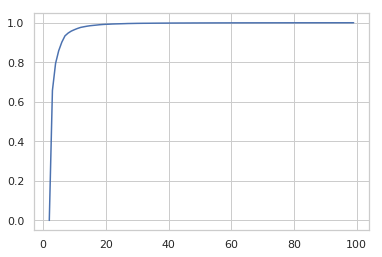

In [32]:
inercias_1, plotagem_1, n_clusters_1 = calculate_wcss(base_1,2,100)

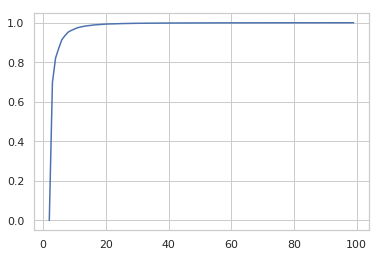

In [33]:
inercias_2, plotagem_2, n_clusters_2 = calculate_wcss(base_2,2,100)

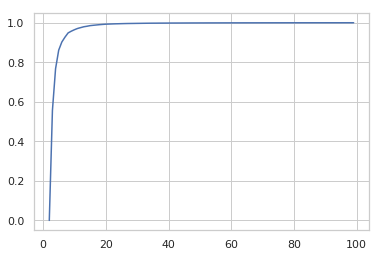

In [34]:
inercias_3, plotagem_3, n_clusters_3 = calculate_wcss(base_3,2,100)

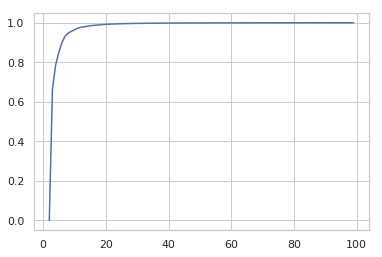

In [35]:
inercias_4, plotagem_4, n_clusters_4 = calculate_wcss(base_4,2,100)

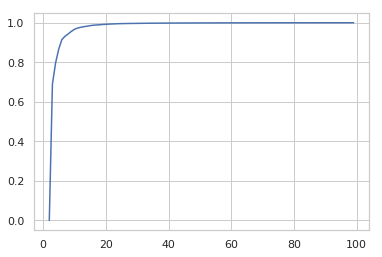

In [36]:
inercias_5, plotagem_5, n_clusters_5 = calculate_wcss(base_5,2,100)

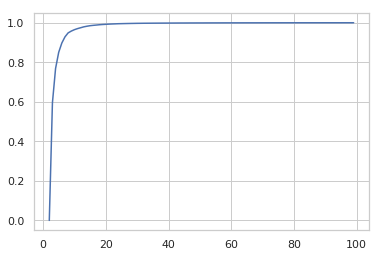

In [37]:
inercias_6, plotagem_6, n_clusters_6 = calculate_wcss(base_6,2,100)

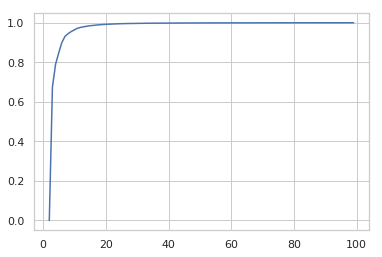

In [38]:
inercias_7, plotagem_7, n_clusters_7 = calculate_wcss(base_7,2,100)

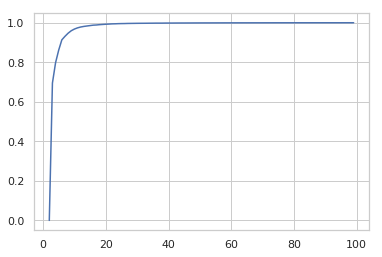

In [39]:
inercias_8, plotagem_8, n_clusters_8 = calculate_wcss(base_8,2,100)

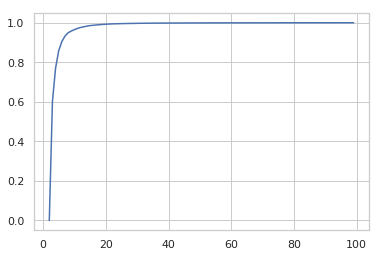

In [40]:
inercias_9, plotagem_9, n_clusters_9 = calculate_wcss(base_9,2,100)

### DISTRIBUIÇÃO DOS CLUSTERS AO FINAL DA TERCEIRA CAMADA

In [59]:
print('Nº de Clusters Base 1:', n_clusters_1),
print('Nº de Clusters Base 2:', n_clusters_2),
print('Nº de Clusters Base 3:', n_clusters_3),
print('Nº de Clusters Base 4:', n_clusters_4),
print('Nº de Clusters Base 5:', n_clusters_5),
print('Nº de Clusters Base 6:', n_clusters_6),
print('Nº de Clusters Base 7:', n_clusters_7),
print('Nº de Clusters Base 8:', n_clusters_8),
print('Nº de Clusters Base 9:', n_clusters_9)

Nº de Clusters Base 1: 97
Nº de Clusters Base 2: 95
Nº de Clusters Base 3: 96
Nº de Clusters Base 4: 96
Nº de Clusters Base 5: 97
Nº de Clusters Base 6: 97
Nº de Clusters Base 7: 97
Nº de Clusters Base 8: 97
Nº de Clusters Base 9: 97


In [60]:
print('Total de Personas:', n_clusters_1+n_clusters_2+n_clusters_3+n_clusters_4+n_clusters_5+n_clusters_6+n_clusters_7+n_clusters_8+n_clusters_9)

Total de Personas: 869


## APLICAÇÃO DOS MODELOS PARA CONSTRUÇÃO DOS 869 CLUSTERS

In [61]:
def modelagem_k_means(base,n_clusters):
    base = base.drop(columns = ['CD_CLI','index','OVER60M4'])
    from sklearn.cluster import KMeans
    modelo = KMeans(n_clusters=n_clusters, n_jobs = -1)
    modelo.fit(base)
    predicoes = modelo.predict(base)
    unique, counts = np.unique(predicoes, return_counts=True)
    predict = dict(zip(unique, counts))
    nome_cluster = list(range(0,len(predict)))
    contagem_cluster = []
    for i in range(0,len(predict)):
        contagem_cluster.append(predict[i])
    resumo_clusterizacao = pd.DataFrame({'ID_CLUSTER':nome_cluster, 'FREQ_CLUSTER':contagem_cluster}).sort_values(by='FREQ_CLUSTER', ascending=False)
    return resumo_clusterizacao, predicoes

In [62]:
tabela_1, preditos_1 = modelagem_k_means(base_1,n_clusters_1)
base_1['CLUSTER'] = preditos_1
tabela_2, preditos_2 = modelagem_k_means(base_2,n_clusters_2)
base_2['CLUSTER'] = preditos_2
tabela_3, preditos_3 = modelagem_k_means(base_3,n_clusters_3)
base_3['CLUSTER'] = preditos_3
tabela_4, preditos_4 = modelagem_k_means(base_4,n_clusters_4)
base_4['CLUSTER'] = preditos_4
tabela_5, preditos_5 = modelagem_k_means(base_5,n_clusters_5)
base_5['CLUSTER'] = preditos_5
tabela_6, preditos_6 = modelagem_k_means(base_6,n_clusters_6)
base_6['CLUSTER'] = preditos_6
tabela_7, preditos_7 = modelagem_k_means(base_7,n_clusters_7)
base_7['CLUSTER'] = preditos_7
tabela_8, preditos_8 = modelagem_k_means(base_8,n_clusters_8)
base_8['CLUSTER'] = preditos_8
tabela_9, preditos_9 = modelagem_k_means(base_9,n_clusters_9)
base_9['CLUSTER'] = preditos_9

### APLICANDO A FASE DE REDUÇÃO A FIM DE AGRUPAR OS CLUSTERS ACERCA DE FAIXAS DE RISCO 

In [63]:
def base_final(base):
    RISCO_ALTO = []
    RISCO_MEDIO_ALTO = []
    RISCO_MEDIO = []
    RISCO_MEDIO_BAIXO = []
    RISCO_BAIXO = []
    numero_do_cluster = list(range(0,len(np.unique(base['CLUSTER']))))
    for i in range(0,len(np.unique(base['CLUSTER']))):
        RISCO_ALTO.append((round((base[base['CLUSTER']==i]['OVER60M4'].value_counts()/base[base['CLUSTER']==i].shape[0])*100,0) <= 85).iloc[0])
        RISCO_MEDIO_ALTO.append(((round((base[base['CLUSTER']==i]['OVER60M4'].value_counts()/base[base['CLUSTER']==i].shape[0])*100,0) > 85) &   (round((base[base['CLUSTER']==i]['OVER60M4'].value_counts()/base[base['CLUSTER']==i].shape[0])*100,0) <= 88)).iloc[0])
        RISCO_MEDIO.append(((round((base[base['CLUSTER']==i]['OVER60M4'].value_counts()/base[base['CLUSTER']==i].shape[0])*100,0) > 88) &   (round((base[base['CLUSTER']==i]['OVER60M4'].value_counts()/base[base['CLUSTER']==i].shape[0])*100,0) <= 91)).iloc[0])
        RISCO_MEDIO_BAIXO.append(((round((base[base['CLUSTER']==i]['OVER60M4'].value_counts()/base[base['CLUSTER']==i].shape[0])*100,0) > 91) &   (round((base[base['CLUSTER']==i]['OVER60M4'].value_counts()/base[base['CLUSTER']==i].shape[0])*100,0) <= 94)).iloc[0])
        RISCO_BAIXO.append((round((base[base['CLUSTER']==i]['OVER60M4'].value_counts()/base[base['CLUSTER']==i].shape[0])*100,0) > 94).iloc[0])                          
    tabela = pd.DataFrame({'CLUSTER':numero_do_cluster,'RISCO_ALTO':RISCO_ALTO,'RISCO_MEDIO_ALTO':RISCO_MEDIO_ALTO, 
                          'RISCO_MEDIO':RISCO_MEDIO,'RISCO_MEDIO_BAIXO':RISCO_MEDIO_BAIXO,'RISCO_BAIXO':RISCO_BAIXO})
    return tabela   

In [64]:
INATIVO_AUTON = base_final(base_1)
ATIVO_AUTON = base_final(base_2)
NOVO_AUTON = base_final(base_3) 
INATIVO_N_IDENT = base_final(base_4)
ATIVO_N_IDENT = base_final(base_5)
NOVO_N_IDENT = base_final(base_6) 
INATIVO_IDENT = base_final(base_7)
ATIVO_IDENT = base_final(base_8) 
NOVO_IDENT = base_final(base_9)

In [65]:
def definicao_risco(tabela, sigla_da_base):
    base = tabela
    base.loc[(base['RISCO_ALTO']== True ) & (base['RISCO_MEDIO_ALTO']==False) &
             (base['RISCO_MEDIO']== False ) & (base['RISCO_MEDIO_BAIXO']==False) &
             (base['RISCO_BAIXO']== False ), 'RISCO_PERSONA'] = sigla_da_base+'_RISCO_ALTO'
    base.loc[(base['RISCO_ALTO']== False ) & (base['RISCO_MEDIO_ALTO']==True) &
             (base['RISCO_MEDIO']== False ) & (base['RISCO_MEDIO_BAIXO']==False) &
             (base['RISCO_BAIXO']== False ), 'RISCO_PERSONA'] = sigla_da_base+'_RISCO_MEDIO_ALTO'
    base.loc[(base['RISCO_ALTO']== False ) & (base['RISCO_MEDIO_ALTO']==False) &
             (base['RISCO_MEDIO']== True ) & (base['RISCO_MEDIO_BAIXO']==False) &
             (base['RISCO_BAIXO']== False ), 'RISCO_PERSONA'] = sigla_da_base+'_RISCO_MEDIO'
    base.loc[(base['RISCO_ALTO']== False ) & (base['RISCO_MEDIO_ALTO']==False) &
             (base['RISCO_MEDIO']== False ) & (base['RISCO_MEDIO_BAIXO']==True) &
             (base['RISCO_BAIXO']== False ), 'RISCO_PERSONA'] = sigla_da_base+'_RISCO_MEDIO_BAIXO' 
    base.loc[(base['RISCO_ALTO']== False ) & (base['RISCO_MEDIO_ALTO']==False) &
             (base['RISCO_MEDIO']== False ) & (base['RISCO_MEDIO_BAIXO']==False) &
             (base['RISCO_BAIXO']== True ), 'RISCO_PERSONA'] = sigla_da_base+'_RISCO_BAIXO' 
    return base

In [66]:
INATIVO_AUTON = definicao_risco(INATIVO_AUTON,'SHIST_AUT')
ATIVO_AUTON = definicao_risco(ATIVO_AUTON,'CHIST_AUT')
NOVO_AUTON = definicao_risco(NOVO_AUTON,'NOVO_AUT') 
INATIVO_N_IDENT = definicao_risco(INATIVO_N_IDENT,'SHIST_NIND')
ATIVO_N_IDENT = definicao_risco(ATIVO_N_IDENT,'CHIST_NIND')
NOVO_N_IDENT = definicao_risco(NOVO_N_IDENT,'NOVO_NIND') 
INATIVO_IDENT = definicao_risco(INATIVO_IDENT,'SHIST_IND')
ATIVO_IDENT = definicao_risco(ATIVO_IDENT,'CHIST_IND') 
NOVO_IDENT = definicao_risco(NOVO_IDENT,'NOVO_IND')

In [67]:
BASE_INATIVO_AUTON = pd.merge(INATIVO_AUTON[['RISCO_PERSONA','CLUSTER']],base_1,on ='CLUSTER',how = 'right')
BASE_ATIVO_AUTON = pd.merge(ATIVO_AUTON[['RISCO_PERSONA','CLUSTER']],base_2,on ='CLUSTER',how = 'right')
BASE_NOVO_AUTON = pd.merge(NOVO_AUTON[['RISCO_PERSONA','CLUSTER']],base_3,on ='CLUSTER',how = 'right')
BASE_INATIVO_N_IDENT = pd.merge(INATIVO_N_IDENT[['RISCO_PERSONA','CLUSTER']],base_4,on ='CLUSTER',how = 'right')
BASE_ATIVO_N_IDENT = pd.merge(ATIVO_N_IDENT[['RISCO_PERSONA','CLUSTER']],base_5,on ='CLUSTER',how = 'right')
BASE_NOVO_N_IDENT = pd.merge(NOVO_N_IDENT[['RISCO_PERSONA','CLUSTER']],base_6,on ='CLUSTER',how = 'right')
BASE_INATIVO_IDENT = pd.merge(INATIVO_IDENT[['RISCO_PERSONA','CLUSTER']],base_7,on ='CLUSTER',how = 'right')
BASE_ATIVO_IDENT = pd.merge(ATIVO_IDENT[['RISCO_PERSONA','CLUSTER']],base_8,on ='CLUSTER',how = 'right')
BASE_NOVO_IDENT = pd.merge(NOVO_IDENT[['RISCO_PERSONA','CLUSTER']],base_9,on ='CLUSTER',how = 'right')

In [68]:
def descritivo(base):
    resumo =  pd.crosstab(base['RISCO_PERSONA'], base['OVER60M4']).apply(lambda r: round((r/r.sum())*100,2), axis=1).sort_values(by=1)
    resumo['FREQ'] = base['RISCO_PERSONA'].value_counts()  
    resumo['FREQ %'] = round((base['RISCO_PERSONA'].value_counts()/base.shape[0])*100,2)
    return resumo

In [69]:
resumo_INATIVO_AUTON = descritivo(BASE_INATIVO_AUTON)
resumo_ATIVO_AUTON = descritivo(BASE_ATIVO_AUTON)
resumo_NOVO_AUTON = descritivo(BASE_NOVO_AUTON)
resumo_INATIVO_N_IDENT = descritivo(BASE_INATIVO_N_IDENT)
resumo_ATIVO_N_IDENT = descritivo(BASE_ATIVO_N_IDENT)
resumo_NOVO_N_IDENT = descritivo(BASE_NOVO_N_IDENT)
resumo_INATIVO_IDENT = descritivo(BASE_INATIVO_IDENT)
resumo_ATIVO_IDENT = descritivo(BASE_ATIVO_IDENT)
resumo_NOVO_IDENT = descritivo(BASE_NOVO_IDENT)

#### Distribuição dos Clusters Pós-Redução

In [70]:
print('Nº Final de Clusters:',len(resumo_INATIVO_AUTON)+len(resumo_ATIVO_AUTON)+len(resumo_NOVO_AUTON)+
    len(resumo_INATIVO_N_IDENT) + len(resumo_ATIVO_N_IDENT) + len(resumo_NOVO_N_IDENT) + len(resumo_INATIVO_IDENT) +
    len(resumo_ATIVO_IDENT) + len(resumo_NOVO_IDENT)),
print('Nº de Clusters Inativo Autonomo:',len(resumo_INATIVO_AUTON)),
print('Nº de Clusters Ativo Autonomo:',len(resumo_ATIVO_AUTON)),
print('Nº de Clusters Novo Autonomo:',len(resumo_NOVO_AUTON)),
print('Nº de Clusters Inativo não Identificado:',len(resumo_INATIVO_N_IDENT)),
print('Nº de Clusters Ativo não Identificado:',len(resumo_ATIVO_N_IDENT)),
print('Nº de Clusters Novo não Identificado:',len(resumo_NOVO_N_IDENT)),
print('Nº de Clusters Inativo Identificado:',len(resumo_INATIVO_IDENT)),
print('Nº de Clusters Ativo Identificado:',len(resumo_ATIVO_IDENT)),
print('Nº de Clusters Novo Identificado:',len(resumo_NOVO_IDENT))

Nº Final de Clusters: 39
Nº de Clusters Inativo Autonomo: 3
Nº de Clusters Ativo Autonomo: 5
Nº de Clusters Novo Autonomo: 5
Nº de Clusters Inativo não Identificado: 4
Nº de Clusters Ativo não Identificado: 5
Nº de Clusters Novo não Identificado: 5
Nº de Clusters Inativo Identificado: 2
Nº de Clusters Ativo Identificado: 5
Nº de Clusters Novo Identificado: 5


#### Exemplo de Frequencia e Distribuição de Inadimplência em um dos ramos da árvore (Cliente Novo Autônomo)

Este ramo gerou 5 folhas (personas) hierarquizadas pela inadimplência e agrupadas pelo risco. Percebe-se que de fato existe um rankeamento dessa inadimplência e uma boa distribuição de frequencia entre essas personas.

In [116]:
resumo_NOVO_AUTON

OVER60M4,0,1,FREQ,FREQ %
RISCO_PERSONA,,,,
NOVO_AUT_RISCO_BAIXO,94.71,5.29,1059,1.01
NOVO_AUT_RISCO_MEDIO_BAIXO,92.61,7.39,25577,24.45
NOVO_AUT_RISCO_MEDIO,89.59,10.41,32170,30.76
NOVO_AUT_RISCO_MEDIO_ALTO,87.12,12.88,34374,32.86
NOVO_AUT_RISCO_ALTO,83.22,16.78,11412,10.91


### Append Bases

In [72]:
frames_pos = [BASE_INATIVO_AUTON ,
BASE_ATIVO_AUTON,
BASE_NOVO_AUTON ,
BASE_INATIVO_N_IDENT,
BASE_ATIVO_N_IDENT,
BASE_NOVO_N_IDENT,
BASE_INATIVO_IDENT,
BASE_ATIVO_IDENT,
BASE_NOVO_IDENT]
BASE_RAW = pd.concat(frames_pos)

In [73]:
frames_pre =  [BASE_INATIVO_AUTONOMO,
BASE_ATIVO_AUTONOMO,
BASE_NOVO_AUTONOMO,
BASE_INATIVO_N_IDENTIFICADO,
BASE_ATIVO_N_IDENTIFICADO,
BASE_NOVO_N_IDENTIFICADO,
BASE_INATIVO_IDENTIFICADO,
BASE_ATIVO_IDENTIFICADO,
BASE_NOVO_IDENTIFICADO]
BASE_RAW_2 = pd.concat(frames_pre)
BASE_RAW_2 = BASE_RAW_2.dropna()

In [74]:
BASE_FINAL = pd.merge(BASE_RAW[['RISCO_PERSONA','CLUSTER','CD_CLI']],BASE_RAW_2,on= 'CD_CLI',how = 'right')

### VISUALIZANDO A BASE FINAL

In [75]:
BASE_FINAL

,RISCO_PERSONA,CLUSTER,CD_CLI,FAIXA_RENDA,FLAG_VEICULO,ESCOLARIDADE,SEXO,IDADE_ANOS_CLIENTE,SETOR_CBO,ANO_RELACIONAMENTO,CEP4,RECORRENCIA_VV_TR,ESTADO_CIVIL,SEGMENTO_2020_CONSOL,UF,VV,FL_PRE_APV_TR,index,OVER60M4,ESCOLARIDADE_CONTINUA,SEXO_CONTINUA,FLAG_VEICULO_CONTINUA,SETOR_CBO_CONTINUA,FAIXA_RENDA_CONTINUA,RECORRENCIA_VV_TR_CONTINUA,UF_CONTINUA,FL_PRE_APV_TR_CONTINUA
0,SHIST_AUT_RISCO_BAIXO,0,148545653,SEM_INFO,0.0,SEM_INFO,F,63.0,AUTONOMO,20.0,1320.0,03 RECORRENTE > 12M,0.0,02 CHIST,SP,12.0,SEM_INFO,22041,0,1.0,1.0,1.0,0.0,2.0,2.0,1.0,1.0
1,SHIST_AUT_RISCO_BAIXO,0,658108107,BAIXA,0.0,SEM_INFO,F,77.0,AUTONOMO,9.0,1320.0,04 RECORRENTE - 15M,2.0,02 CHIST,SP,7.0,SEM_INFO,24201,0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0
2,SHIST_AUT_RISCO_BAIXO,0,548544018,BAIXA,1.0,SEM_INFO,F,67.0,AUTONOMO,11.0,1323.0,SEM_INFO,2.0,02 CHIST,SP,16.0,SEM_INFO,25209,0,1.0,1.0,0.0,0.0,1.0,3.0,1.0,1.0
3,SHIST_AUT_RISCO_BAIXO,0,494126450,BAIXA,1.0,SEM_INFO,F,67.0,AUTONOMO,12.0,1322.0,SEM_INFO,0.0,02 CHIST,SP,13.0,SEM_INFO,26073,0,1.0,1.0,0.0,0.0,1.0,3.0,1.0,1.0
4,SHIST_AUT_RISCO_BAIXO,0,197829481,ALTA,1.0,SEM_INFO,F,48.0,AUTONOMO,17.0,1320.0,SEM_INFO,0.0,02 CHIST,SP,43.0,SEM_INFO,26577,0,1.0,1.0,0.0,0.0,0.0,3.0,1.0,1.0
5,SHIST_AUT_RISCO_BAIXO,0,134370295,BAIXA,0.0,SEM_INFO,F,64.0,AUTONOMO,0.0,1322.0,SEM_INFO,0.0,02 CHIST,SP,0.0,0,43423,0,1.0,1.0,1.0,0.0,1.0,3.0,1.0,2.0
6,SHIST_AUT_RISCO_BAIXO,0,474301184,BAIXA,0.0,SEM_INFO,F,65.0,AUTONOMO,12.0,1321.0,SEM_INFO,2.0,02 CHIST,SP,7.0,0,43567,0,1.0,1.0,1.0,0.0,1.0,3.0,1.0,2.0
7,SHIST_AUT_RISCO_BAIXO,0,275760650,SEM_INFO,0.0,SEM_INFO,F,72.0,AUTONOMO,15.0,1321.0,04 RECORRENTE - 15M,2.0,02 CHIST,SP,3.0,0,44143,0,1.0,1.0,1.0,0.0,2.0,0.0,1.0,2.0
8,SHIST_AUT_RISCO_BAIXO,0,335456480,BAIXA,0.0,SEM_INFO,M,71.0,AUTONOMO,14.0,1329.0,04 RECORRENTE - 15M,0.0,02 CHIST,SP,13.0,0,45583,0,1.0,2.0,1.0,0.0,1.0,0.0,1.0,2.0
9,SHIST_AUT_RISCO_BAIXO,0,668291010,SEM_INFO,0.0,SEM_INFO,F,56.0,AUTONOMO,8.0,1321.0,01 RECORRENTE ULT 6M,0.0,02 CHIST,SP,6.0,0,46125,0,1.0,1.0,1.0,0.0,2.0,4.0,1.0,2.0


### VISUALIZANDO ALGUNS RESULTADOS

DISTRIBUIÇÃO DA INADIMPLÊNCIA ENTRE OS 38 CLUSTERS


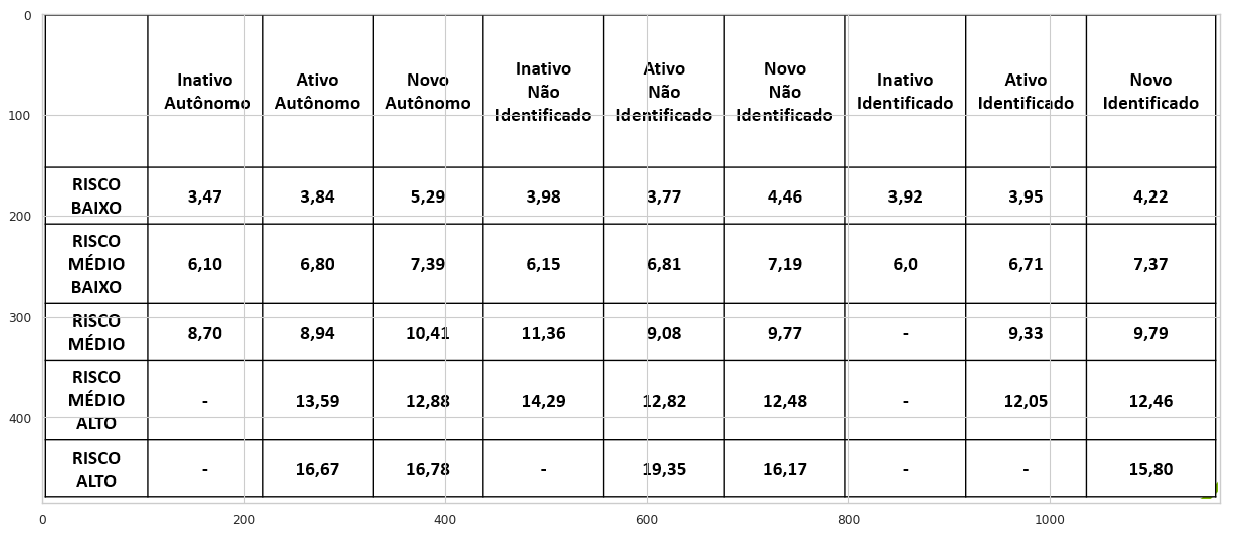

In [77]:
s3 = boto3.resource('s3', region_name='us-east-2')
bucket = s3.Bucket(NM_BUCKET)
object = bucket.Object(CAMINHO + 'pers2.png')
tmp = tempfile.NamedTemporaryFile()

with open(tmp.name, 'wb') as f:
    object.download_fileobj(f)
    img=mpimg.imread(tmp.name)
print('DISTRIBUIÇÃO DA INADIMPLÊNCIA ENTRE OS 38 CLUSTERS')
fig=plt.figure(figsize=(19, 17), dpi= 80, facecolor='w', edgecolor='k')
plt.imshow(img)

DISTRIBUIÇÃO DAS FREQUÊNCIAS ENTRE OS 38 CLUSTERS


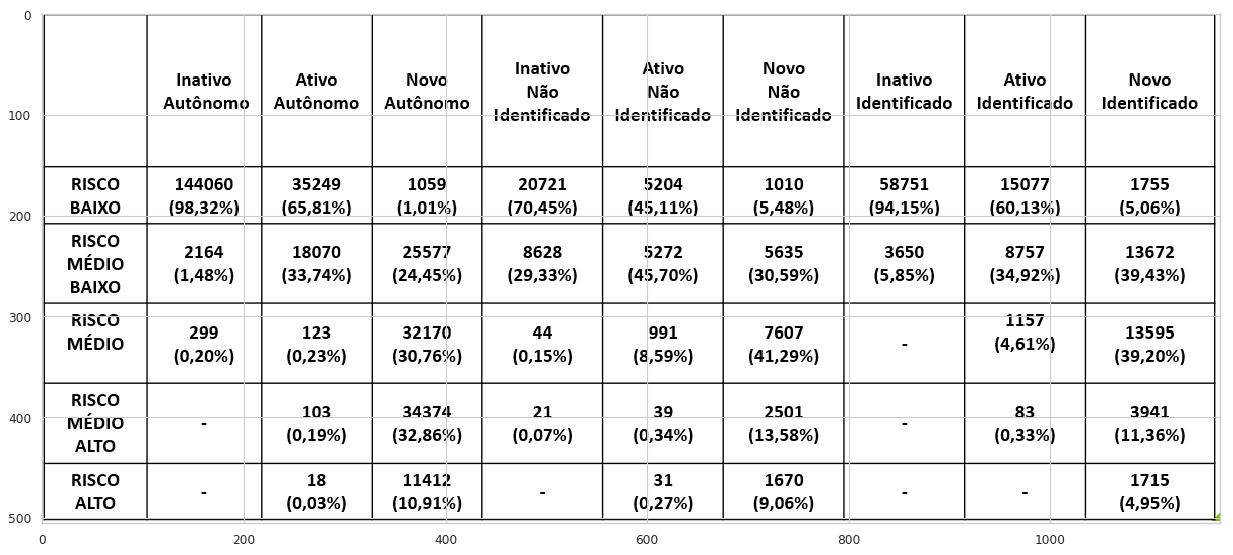

In [78]:
s3 = boto3.resource('s3', region_name='us-east-2')
bucket = s3.Bucket(NM_BUCKET)
object = bucket.Object(CAMINHO + 'pers3.png')
tmp = tempfile.NamedTemporaryFile()

with open(tmp.name, 'wb') as f:
    object.download_fileobj(f)
    img=mpimg.imread(tmp.name)
print('DISTRIBUIÇÃO DAS FREQUÊNCIAS ENTRE OS 38 CLUSTERS')
fig=plt.figure(figsize=(19, 17), dpi= 80, facecolor='w', edgecolor='k')
plt.imshow(img)

OBSERVANDO INTERNAMENTE ALGUMAS PERSONAS


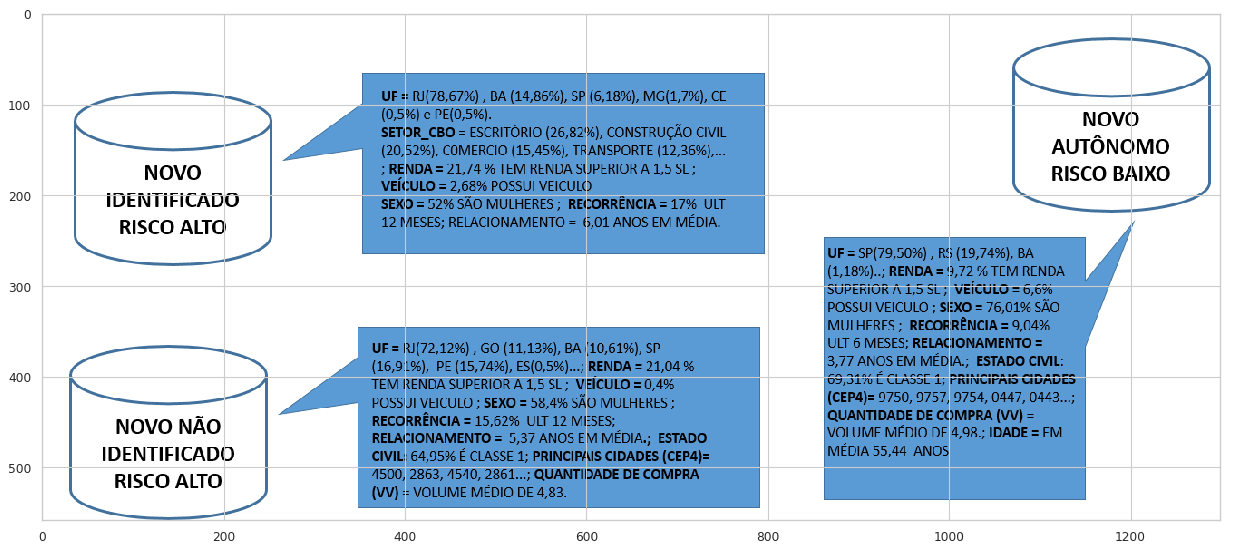

In [79]:
s3 = boto3.resource('s3', region_name='us-east-2')
bucket = s3.Bucket(NM_BUCKET)
object = bucket.Object(CAMINHO + 'pers4.png')
tmp = tempfile.NamedTemporaryFile()

with open(tmp.name, 'wb') as f:
    object.download_fileobj(f)
    img=mpimg.imread(tmp.name)
print('OBSERVANDO INTERNAMENTE ALGUMAS PERSONAS')
fig=plt.figure(figsize=(19, 17), dpi= 80, facecolor='w', edgecolor='k')
plt.imshow(img)

#### Podemos verificar que essa metodologia não é complexa e trás um nível interessante de detalhamento dentro de cada persona. Para otimizar essa informação sem perder interpretabilidade, seria interessante criar novos ramos a partir das folhas finais (personas de crédito), acrescentando novas variáveis que identificassem mais o risco de inadimplência.